# Gender, Mental Illness, and Crime in the United States, 2004 Analysis

## Instalacja bibliotek

In [1]:
!pip install -r requirements.txt

## Sprawdzenie czy dane są dostępne

In [2]:
import os

file_path = os.path.join(os.getcwd(), 'ICPSR_27521-V1', 'ICPSR_27521', 'DS0001', '27521-0001-Data.tsv')
if not os.path.exists(file_path):
    raise FileNotFoundError(f'{file_path} nie został znaleziony\n Sprawdź ścieżkę')

## Wczytanie danych

In [3]:
import pandas as pd
df = pd.read_csv(file_path, sep='\t', low_memory=False)

Sprawdzenie wymiarów zbioru danych

In [4]:
print(df.shape[0], 'rzędów')
print(df.shape[1], 'kolumn')

55602 rzędów
3011 kolumn


Przetestowałem wykorzystanie dataframe z biblioteki `dask`, ale większość poleceń poza wczytywaniem była znacząco dłuższa (wykorzystanie `.compute()` dla wczytanego dataframe zajmowało 2-3x więcej czasu niż wczytanie przy pomocy `pandas`)

## Wstępna analiza

### Cecha do predykcji

Jako cecha do predykcji wybrana została kolumna `MDEYR`, która opisuje czy u respondenta w ostatnim roku wystąpił silny epizod depresyjny. Kolumna `DEPRESSIONINDEX` została odrzucona, ponieważ autorzy dodali przy niej komentarz `don’t use this one` (strona 1530 w Codebook), a dla wskaźnika `DEPRESSIONINDEX2` brakuje 93.2% danych. Z tego względu zadanie predykcji będzie zadaniem klasyfikacji, a nie regresji.

Pierwszym krokiem jest sprawdzenie ile jest brakujących danych w kolumnie `MDEYR`. Na podstawie Codebook poszczególne wartości w tej kolumnie oznaczają:
- `1` - respondent miał silny epizod depresyjny w ostatnim roku,
- `2` - respondent nie miał silnego epizodu depresyjnego w ostatnim roku,
- `3` - respondent poza zakresem - oznacza to, że był w próbce osób, które nie otrzymały pytań na temat zrowia psychicznego,
- `-9` - brak danych.

Na tej podstawie respondenci, dla których pojawiła się wartość `3` lub `-9` zostaną odrzuceni, ponieważ nie byłoby możliwości ich wykorzystania w uczeniu ze względu na brak ground truth. W innym przypadku mógłby to być zbiór testowy.

In [5]:
print(df['MDEYR'].value_counts())

num_of_missing_data = df['MDEYR'].value_counts()[-9] + df['MDEYR'].value_counts()[3]
print(num_of_missing_data, 'rzędów z brakującymi danymi')
print(df.shape[0] - num_of_missing_data, 'rzędów bez brakujących danych')

MDEYR
 2    33026
 3    18630
 1     3506
-9      440
Name: count, dtype: int64
19070 rzędów z brakującymi danymi
36532 rzędów bez brakujących danych


In [6]:
df = df[~df['MDEYR'].isin([-9, 3])]
df = df.reset_index(drop=True)
print(df.shape[0], 'rzędów po usunięciu brakujących danych')
# Reset index

36532 rzędów po usunięciu brakujących danych


Po usunięciu brakujących danych, rozkłąd wartości wygląda następująco.

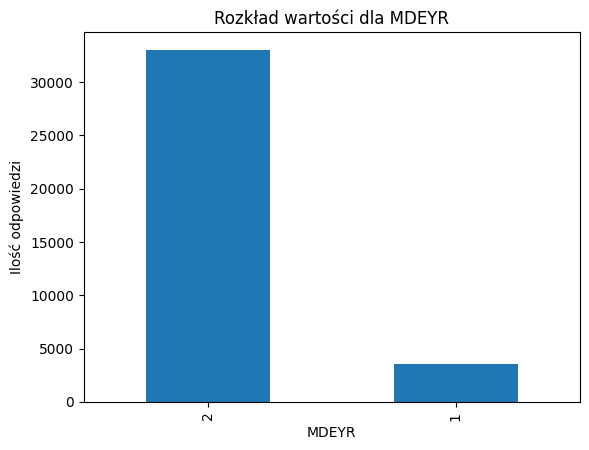

In [7]:
import matplotlib.pyplot as plt
df['MDEYR'].value_counts().plot(kind='bar')
plt.title('Rozkład wartości dla MDEYR')
plt.xlabel('MDEYR')
plt.ylabel('Ilość odpowiedzi')
plt.show()

Na rysunku powyżej widać, że większość respondentów odpowiedziała, że w ostatnim roku nie miała silnego stanu depresyjnego.

Utworzona zostanie również nowa kolumna `DEPRESSIONTYPELASTYR`, która przyjmie następujące wartości:
- `0`: brak depresji,
- `1`: 'czysta' depresja,
- `2`: depresja somatyczna;

Do jej powstania wykorzystane zostaną kolumny:
- czy wystąpił silny epizod depresyjny w ostatnim roku `MDEYR`,
- przy stanach depresyjnych zmmiany apetytu u dorosłych `AD_MDEA3` i młodzieży `YO_MDEA3`,
- przy stanach depresyjnych problemy ze snem u dorosłych `AD_MDEA4` i młodzieży `YO_MDEA4`,
- przy stanach depresyjnych poczucie zmęczenia u dorosłych `AD_MDEA6` i młodzieży `YO_MDEA6`.
  
Następnym krokiem jest utworzenie nowej kolumny i dodanie informacji o symptomach.

In [8]:
def depression_type(row):
    if row['MDEYR'] == 1 and row['YO_MDEA3'] == 1 and row['YO_MDEA4'] == 1 and row['YO_MDEA6'] == 1:
        return 2
    elif row['MDEYR'] == 1 and row['AD_MDEA3'] == 1 and row['AD_MDEA4'] == 1 and row['AD_MDEA6'] == 1:
        return 2
    elif row['MDEYR'] == 1:
        return 1
    else:
        return 0
    
df['DEPRESSIONTYPELASTYR'] = df.apply(depression_type, axis=1)

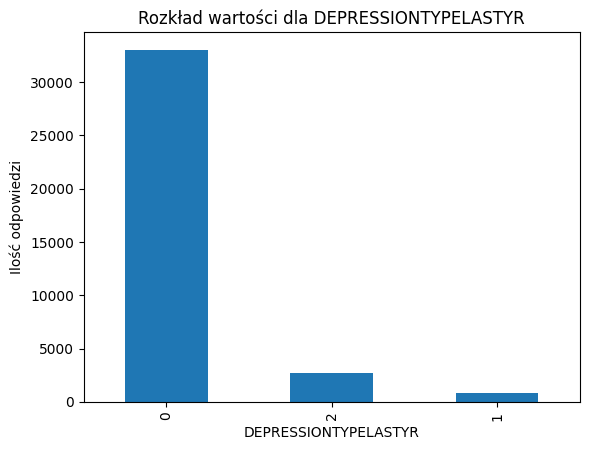

In [9]:
df['DEPRESSIONTYPELASTYR'].value_counts().plot(kind='bar')
plt.title('Rozkład wartości dla DEPRESSIONTYPELASTYR')
plt.xlabel('DEPRESSIONTYPELASTYR')
plt.ylabel('Ilość odpowiedzi')
plt.show()

Jak widać, większość osób, które miały silny epizod depresyjny miały również 3 symptomy somatyczne.

### Wybór i czyszczenie cech

Po przejrzeniu następujących artykułów:
- Silverstein, Brett; Levin, Eitan, "Differences in the developmental
patterns of depression with and without additional somatic symptoms."
Psychiatry Research. Dec 2014, 220, (1-2), 254 - 257. DOI:
10.1016/j.psychres.2014.07.054
- Thompson, Melissa, "Gender, Mental Illness, and Crime." Final Technical
Report. NCJ 224028, Sep 2008. 2007-IJ-CX-0004

oraz przeszukaniu Codebook, do wstępnej analizy wybrane zostały następujące cechy:
- płeć: `IRSEX`,
- wiek: `CATAG7`,
- rasa: `NEWRACE2`,
- współczynnik uzależnienia od narkotyków: `ANYINDEX`,
- kiedy ostatnio brał jakiekolwiek nielegalne narkotyki: `ANYILLICITRC`,
- czy używał marihuany/kokainy w ostatnim roku: `MJCOKELY`
- czy kiedykolwiek użył środków przeciwbólowych do celów niemedycznych: `ANLEVER`,
- czy popełnił przestępstwo: `ANYCRIME`,
- czy kiedykolwiek został aresztowany: `CRIMEHIST`,
- czy pracuje lub chodzi do szkoły: `WORKSCHOOL`,
- poziom edukacji: `IREDUC2`,
- ogólny poziom zdrowia: `HEALTH2`,
- czy respondent ma jakiekolwiek ubezpieczenie zdrowotne: `ANYHLTI2`,
- stan cywilny: `IRMARIT`,
- typ mieszkania: `CACHAR`,
- dochód rodziny: `INCOME`,
- uzależnienie od narkotyków lub alkoholu w ostatnim roku: `DPILLALC`,
- nadużywanie alkoholu w ostatnim roku: `ABUSEALC`,
- gęstość zaludnienia: `REVERSEPOP`.

In [10]:
columns_to_use = [
    'MDEYR',
    'DEPRESSIONTYPELASTYR',
    'IRSEX',
    'CATAG7',
    'NEWRACE2',
    'ANYINDEX',
    'ANYILLICITRC',
    'MJCOKELY',
    'ANLEVER',
    'ANYCRIME',
    'CRIMEHIST',
    'WORKSCHOOL',
    'IREDUC2',
    'HEALTH2',
    'ANYHLTI2',
    'IRMARIT',
    'CACHAR',
    'INCOME',
    'DPILLALC',
    'ABUSEALC',
    'REVERSEPOP'
]

df = df[columns_to_use]
int64_columns = df.select_dtypes(include=['int64']).columns

W niektórych z kolumn wartości wymagają ręcznego poprawienia, ponieważ zostały dobrane w sposób, który mógłby utrudnić analizę.

In [11]:
values_to_replace = {
    'MDEYR': [[2, 0]],
    'IRSEX': [[2, 0]],
    'ANYILLICITRC': [[9, 0], [1, 4], [3, 1], [4, 3]],
    'ANLEVER': [[81, 0], [91, 0]],
    'IRMARIT': [[99, 5]],
    'WORKSCHOOL': [[0, 2]]
}

In [12]:
for column, values in values_to_replace.items():
    for value in values:
        df[column] = df[column].replace(value[0], value[1])

Słownik z oznaczeniami brakujących danych w poszczególnych kolumnach

In [13]:
missing_values = {
    'IRSEX': [],
    'CATAG7': [],
    'NEWRACE2': [],
    'ANYINDEX': [-1],
    'ANYILLICITRC': [],
    'MJCOKELY': [],
    'ANLEVER': [97, 98],
    'ANYCRIME': [-1],
    'CRIMEHIST': [-1],
    'WORKSCHOOL': [-1],
    'IREDUC2': [],
    'HEALTH2': [-9],
    'ANYHLTI2': [94, 97, 98],
    'IRMARIT': [],
    'CACHAR': [-9],
    'INCOME': [],
    'DPILLALC': [],
    'ABUSEALC': [],
    'REVERSEPOP': []    
}

Obliczenie ilości brakujących danych w każdej kolumnie (i procentowego udziału)

In [14]:
indices_with_missing_data = []

for column, missing_values_list in missing_values.items():
    mask = df[column].isin(missing_values_list)
    df.loc[mask, column] = None
    num_of_missing_data = mask.sum()
    print(f'{column}: {num_of_missing_data} ({num_of_missing_data / df.shape[0] * 100:.2f}%)')
    indices_with_missing_data.extend(df[mask].index.to_list())

IRSEX: 0 (0.00%)
CATAG7: 0 (0.00%)
NEWRACE2: 0 (0.00%)
ANYINDEX: 25 (0.07%)
ANYILLICITRC: 0 (0.00%)
MJCOKELY: 0 (0.00%)
ANLEVER: 134 (0.37%)
ANYCRIME: 21 (0.06%)
CRIMEHIST: 74 (0.20%)
WORKSCHOOL: 4 (0.01%)
IREDUC2: 0 (0.00%)
HEALTH2: 10 (0.03%)
ANYHLTI2: 327 (0.90%)
IRMARIT: 0 (0.00%)
CACHAR: 7 (0.02%)
INCOME: 0 (0.00%)
DPILLALC: 0 (0.00%)
ABUSEALC: 0 (0.00%)
REVERSEPOP: 0 (0.00%)


Jeżeli w jakimś rzędzie brakuje przynajmniej 2 wartości to zostanie on usunięty

In [15]:
from collections import Counter
index_counts = Counter(indices_with_missing_data)
indices_to_remove = [index for index, count in index_counts.items() if count >= 2]

print(indices_to_remove)
df = df.drop(indices_to_remove)
df = df.reset_index(drop=True)

[11160, 33603, 18284, 24234, 25274, 32562, 23890, 30175, 34604, 10587]


Sprawdzenie typów wartości w poszczególnych kolumnach

In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36522 entries, 0 to 36521
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MDEYR                 36522 non-null  int64  
 1   DEPRESSIONTYPELASTYR  36522 non-null  int64  
 2   IRSEX                 36522 non-null  float64
 3   CATAG7                36522 non-null  float64
 4   NEWRACE2              36522 non-null  float64
 5   ANYINDEX              36499 non-null  float64
 6   ANYILLICITRC          36522 non-null  float64
 7   MJCOKELY              36522 non-null  float64
 8   ANLEVER               36393 non-null  float64
 9   ANYCRIME              36503 non-null  float64
 10  CRIMEHIST             36453 non-null  float64
 11  WORKSCHOOL            36519 non-null  float64
 12  IREDUC2               36522 non-null  float64
 13  HEALTH2               36512 non-null  float64
 14  ANYHLTI2              36200 non-null  float64
 15  IRMARIT            

In [17]:
print(df['ANYINDEX'].nunique())

12


Ze względu na fakt, że kolumna `ANYINDEX` posiada wartości typu `float64`, gdzie jest 12 unikalnych wartości, to dla ułatwienia wiersze, w których brakuje wartości w tej kolumnie, zostaną usunięte. 

In [18]:
df = df.dropna(subset=['ANYINDEX'])
df = df.reset_index(drop=True)

Pozostałe brakujące wartości zostaną uzupełnione przy pomocy metody KNN.

Uzasadnienie dla poszczególnych kolumns:
- dla `ANYINDEX`, `ANYCRIME`, `CRIMEHIST`, `WORKSCHOOL` wartość `-1` oznacza `Blank` czyli brak wpisanej wartości, a nie ma podanego powodu (nie wynika z tego, że na inne pytanie odpowiedział tak, że tych pytań nie otrzymał, tylko po prostu nie zaznaczył w tych kolumnach nic),
- dla `ANLEVER` wartość `97` oznacza `REFUSED`, które możnaby traktować, że ktoś nie chce podać odpowiedzi, że korzystał kiedyś ze środków przeciwbólowych poza zastosowaniami medycznymi, ze względu na obawę jak go ocenią, ale nie ma pewności, że tak było, a wartość `98` oznacza `BLANK (NO ANSWER)` czyli jest to sytuacja jak dla `ANYINDEX`,
- dla `HEALTH2` wartość `-9` oznacza albo `DON'T KNOW` albo `REFUSED`, więc ponownie nie można wnioskować,
- dla `ANYHLTI2` wartość `94` oznacza `DON'T KNOW`, `97` oznacza `REFUSED`, a `98` oznacza `OTHER MISSING`, więc ponownie brak odpowiedzi nie wynika z odpowiedzi na inne pytanie; duża liczba brakujących odpowiedzi wynika prawdopodobnie z faktu, że w badaniu brała udział młodzież, która może się nie interesować tym czy ma ubezpieczenie,
- dla `CACHAR` wartość `-9` oznacza `BLANK`, a więc ponownie wynika to z nie zaznaczeniem odpowiedzi.

Ze względu na to, że braki nie wynikają z odpowiedzi na inne pytania to uzupełnienie wartości przy pomocy metody k-najbliższych sąsiadów jest uzasadnione. Możnaby też analizować czy odpowiedź `REFUSED` nie ma na celu czegoś ukryć, ale to mogłoby prowadzić do błędnych wniosków.

In [19]:
# Use KNN Imputer to fill missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=11)
df_imputed = imputer.fit_transform(df)

In [20]:
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
df_imputed[int64_columns] = df_imputed[int64_columns].astype('int64')

In [21]:
data_df = df_imputed.copy()

### Analiza czynników wpływających na występowanie depresji

Wyświetlenie przykładowych danych

In [22]:
print(data_df.head())

   MDEYR  DEPRESSIONTYPELASTYR  IRSEX  CATAG7  NEWRACE2  ANYINDEX  \
0      0                     0      1       5         7  0.142857   
1      0                     0      1       4         1  0.142857   
2      0                     0      1       7         1  0.142857   
3      0                     0      1       5         1  0.500000   
4      0                     0      0       7         1  0.142857   

   ANYILLICITRC  MJCOKELY  ANLEVER  ANYCRIME  ...  WORKSCHOOL  IREDUC2  \
0             3         1        0         0  ...           1       11   
1             1         0        0         0  ...           2       10   
2             0         0        0         0  ...           2       10   
3             3         1        1         0  ...           1       10   
4             1         0        0         0  ...           1        8   

   HEALTH2  ANYHLTI2  IRMARIT  CACHAR  INCOME  DPILLALC  ABUSEALC  REVERSEPOP  
0        1         1        4       7       3         0     

Wyświetlenie statystyk poszczególnych kolumn

In [23]:
print(data_df.describe())

              MDEYR  DEPRESSIONTYPELASTYR         IRSEX        CATAG7  \
count  36499.000000          36499.000000  36499.000000  36499.000000   
mean       0.095920              0.170114      0.486013      3.847229   
std        0.294486              0.538118      0.499811      2.077345   
min        0.000000              0.000000      0.000000      1.000000   
25%        0.000000              0.000000      0.000000      2.000000   
50%        0.000000              0.000000      0.000000      4.000000   
75%        0.000000              0.000000      1.000000      6.000000   
max        1.000000              2.000000      1.000000      7.000000   

           NEWRACE2      ANYINDEX  ANYILLICITRC      MJCOKELY       ANLEVER  \
count  36499.000000  36499.000000  36499.000000  36499.000000  36499.000000   
mean       2.280062      0.165461      0.785117      0.173539      0.153812   
std        2.205180      0.096967      1.056589      0.378718      0.360774   
min        1.000000      0

In [24]:
depression_type_labels = {
    0: 'Brak depresji',
    1: 'Depresja',
    2: 'Depresja z objawami somatycznymi'
}

data_df['DEPRESSIONTYPELASTYR_str'] = data_df['DEPRESSIONTYPELASTYR'].map(depression_type_labels)

W zbiorze danych widoczne jest, że wiele cech ma małą wartość odchylenia standardowego, co oznacza, że większość respondentów odpowiedziała w jednakowy sposób na dane pytanie.

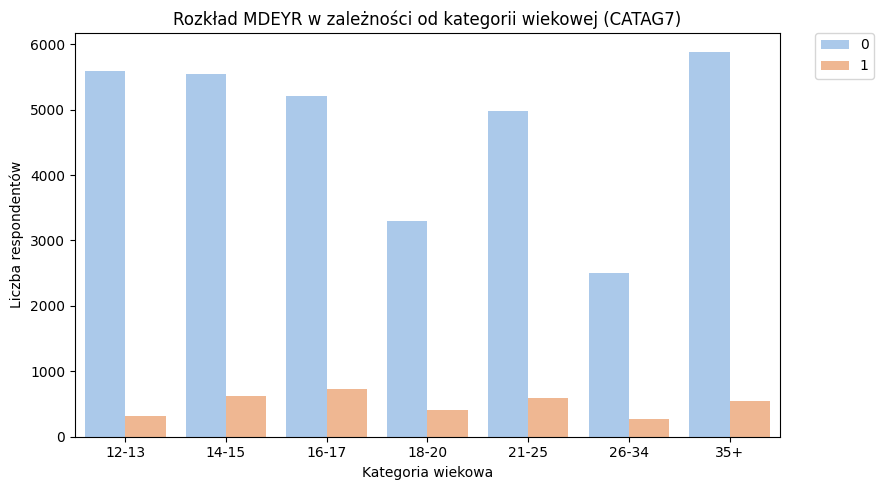

In [25]:
import seaborn as sns

age_labels = {
    1: '12-13',
    2: '14-15',
    3: '16-17',
    4: '18-20',
    5: '21-25',
    6: '26-34',
    7: '35+'
}

data_df['CATAG7_str'] = data_df['CATAG7'].map(age_labels)

plt.figure(figsize=(8, 5))
sns.countplot(
    data=data_df,
    x='CATAG7_str',
    hue='MDEYR',
    palette='pastel',
    order=['12-13', '14-15', '16-17', '18-20', '21-25', '26-34', '35+']
)

plt.title('Rozkład MDEYR w zależności od kategorii wiekowej (CATAG7)')
plt.xlabel('Kategoria wiekowa')
plt.ylabel('Liczba respondentów')
plt.legend(title='MDEYR', labels=['0 = Brak epizodu', '1 = Epizod depresyjny'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


Wyniki pokazują, że epizody depresyjne (MDEYR = 1)  najczęsciej w grupie wiekowej 16–17 lat. Jednocześnie większość respondentów w każdej kategorii wiekowej nie doświadczyła epizodów depresyjnych w ostatnim roku.

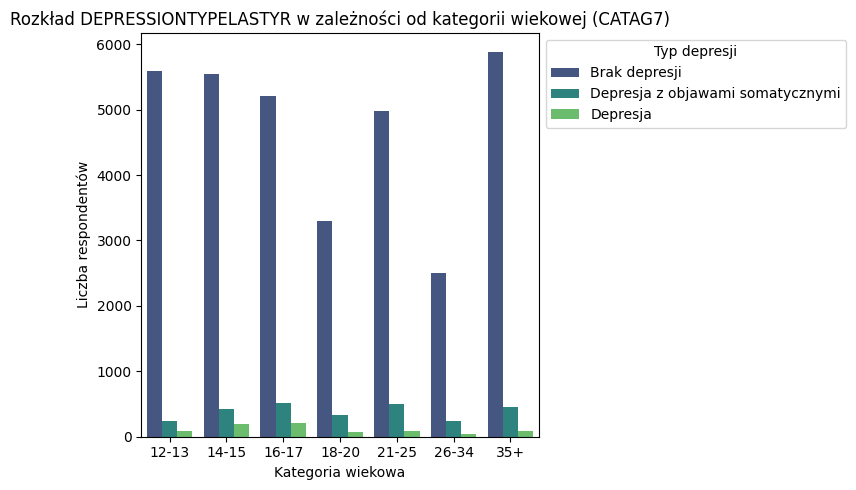

In [26]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=data_df,
    x='CATAG7_str',
    hue='DEPRESSIONTYPELASTYR_str',
    palette='viridis',
    order=['12-13', '14-15', '16-17', '18-20', '21-25', '26-34', '35+']
)

plt.title('Rozkład DEPRESSIONTYPELASTYR w zależności od kategorii wiekowej (CATAG7)')
plt.xlabel('Kategoria wiekowa')
plt.ylabel('Liczba respondentów')
plt.legend(
    title='Typ depresji',
    loc='upper left',
    bbox_to_anchor=(1, 1)
)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

W każdej grupie wiekowej częściej występuje depresja somatyczna niż "zwykła". Najmniejsza różnica pomiędzy udziałem depresji somatycznej i zwykłej jest dla grupy wiekowej `12-13`

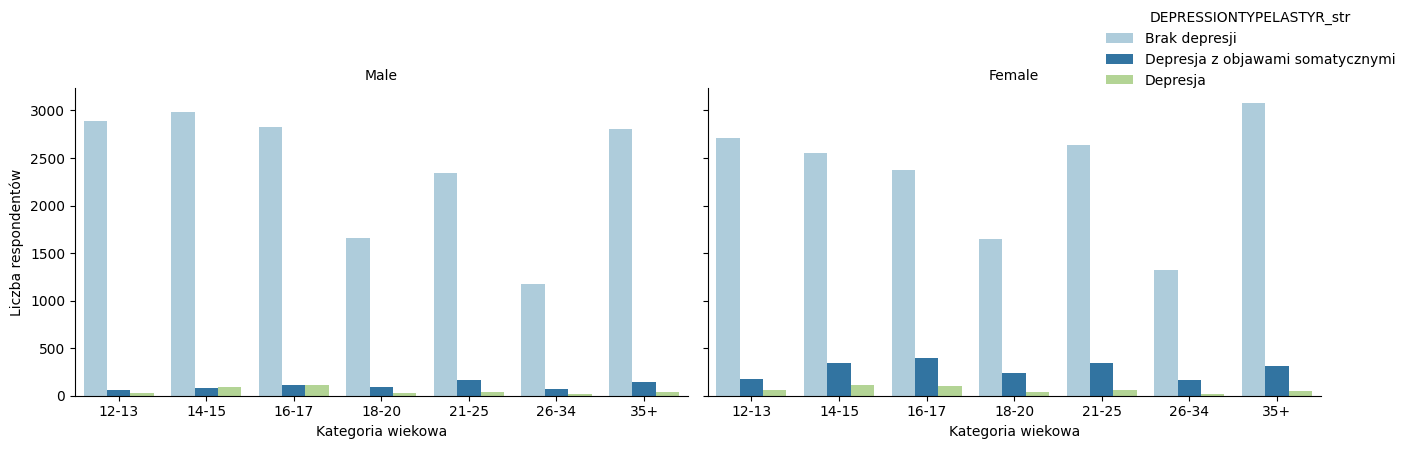

Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i kategorii wiekowej
DEPRESSIONTYPELASTYR_str  Brak depresji  Depresja  \
IRSEX_str CATAG7_str                                
Female    12-13                    2706        59   
          14-15                    2557       109   
          16-17                    2378       101   
          18-20                    1650        42   
          21-25                    2633        57   
          26-34                    1326        21   
          35+                      3079        52   
Male      12-13                    2887        26   
          14-15                    2984        88   
          16-17                    2822       111   
          18-20                    1654        33   
          21-25                    2343        36   
          26-34                    1179        16   
          35+                      2800        42   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somat

In [27]:
sex_labels = {
    1: 'Male',
    0: 'Female'
}
data_df['IRSEX_str'] = data_df['IRSEX'].map(sex_labels)

g = sns.catplot(
    data=data_df,
    x='CATAG7_str',
    hue='DEPRESSIONTYPELASTYR_str',
    col='IRSEX_str',
    kind='count',
    order=['12-13', '14-15', '16-17', '18-20', '21-25', '26-34', '35+'],
    palette='Paired',
    height=4,
    aspect=1.3,
    legend_out=True
)

g.set_axis_labels("Kategoria wiekowa", "Liczba respondentów")
g.set_titles("{col_name}")
g._legend.set_bbox_to_anchor((1.05, 1))

plt.tight_layout()
plt.show()


table_crosstab = pd.crosstab(
    index=[data_df['IRSEX_str'], data_df['CATAG7_str']],
    columns=data_df['DEPRESSIONTYPELASTYR_str']
)

table_crosstab_percentage = table_crosstab.div(table_crosstab.sum(axis=1), axis=0) * 100
table_crosstab = table_crosstab.join(table_crosstab_percentage, rsuffix='_percentage')

print("Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i kategorii wiekowej")
print(table_crosstab)

Na podstawie danych widocznych powyżej można wyciągnąć następujące wnioski:
- dla obu płci najmniejszy procent osób z depresją jest w grupie wiekowej `12-13`,
- kategoria `14-15` wśród chłopców jest jedyną, gdzie więcej respondentów miało "czystą depresję" niż depresję somatyczną,
- kobiety mają w każdej grupie wiekowej większy procent respondentów z depresją ogólnie, a także z depresją somatayczną, w przypadku depresji somatycznej jedynie w grupie wiekowej 16-17 mężczyźni mają większy udział procentowy osób z czystą depresją niż kobiety w tej samej kategorii wiekowej

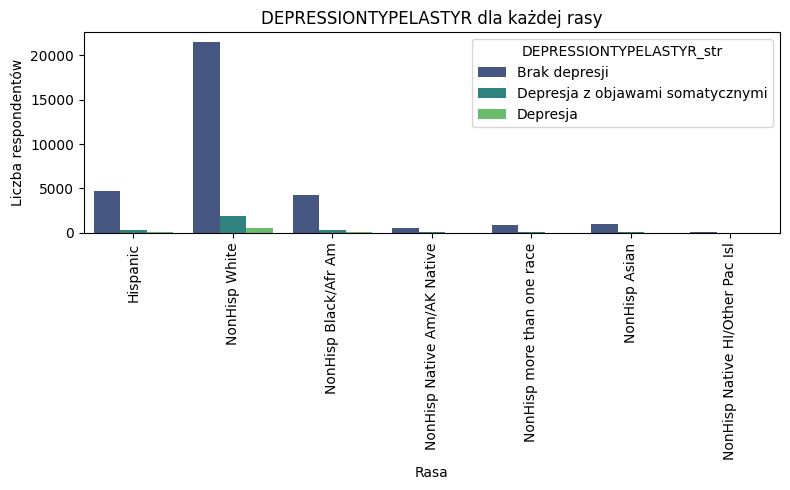

Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i kategorii wiekowej
DEPRESSIONTYPELASTYR_str         Brak depresji  Depresja  \
NEWRACE2_str                                               
Hispanic                                  4669       103   
NonHisp Asian                             1042        21   
NonHisp Black/Afr Am                      4230        84   
NonHisp Native Am/AK Native                502        10   
NonHisp Native HI/Other Pac Isl            123         2   
NonHisp White                            21510       535   
NonHisp more than one race                 922        38   

DEPRESSIONTYPELASTYR_str         Depresja z objawami somatycznymi  \
NEWRACE2_str                                                        
Hispanic                                                      353   
NonHisp Asian                                                  69   
NonHisp Black/Afr Am                                          284   
NonHisp Native

In [28]:
race_labels = {
    1: 'NonHisp White',
    2: 'NonHisp Black/Afr Am',
    3: 'NonHisp Native Am/AK Native',
    4: 'NonHisp Native HI/Other Pac Isl',
    5: 'NonHisp Asian',
    6: 'NonHisp more than one race',
    7: 'Hispanic'
}
data_df['NEWRACE2_str'] = data_df['NEWRACE2'].map(race_labels)

plt.figure(figsize=(8, 5))
sns.countplot(
    data=data_df,
    x='NEWRACE2_str',
    hue='DEPRESSIONTYPELASTYR_str',
    palette='viridis'
)
plt.title('DEPRESSIONTYPELASTYR dla każdej rasy')
plt.xlabel('Rasa')
plt.ylabel('Liczba respondentów')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


table_crosstab = pd.crosstab(
    index=data_df['NEWRACE2_str'],
    columns=data_df['DEPRESSIONTYPELASTYR_str']
)

table_crosstab_percentage = table_crosstab.div(table_crosstab.sum(axis=1), axis=0) * 100
table_crosstab = table_crosstab.join(table_crosstab_percentage, rsuffix='_percentage')

print("Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i kategorii wiekowej")
print(table_crosstab)

Różnice pomiędzy rasami w przypadku ogólnego występowania depresji są nieznaczne, jedynie większa różnica występuje dla `NonHisp more than one race`

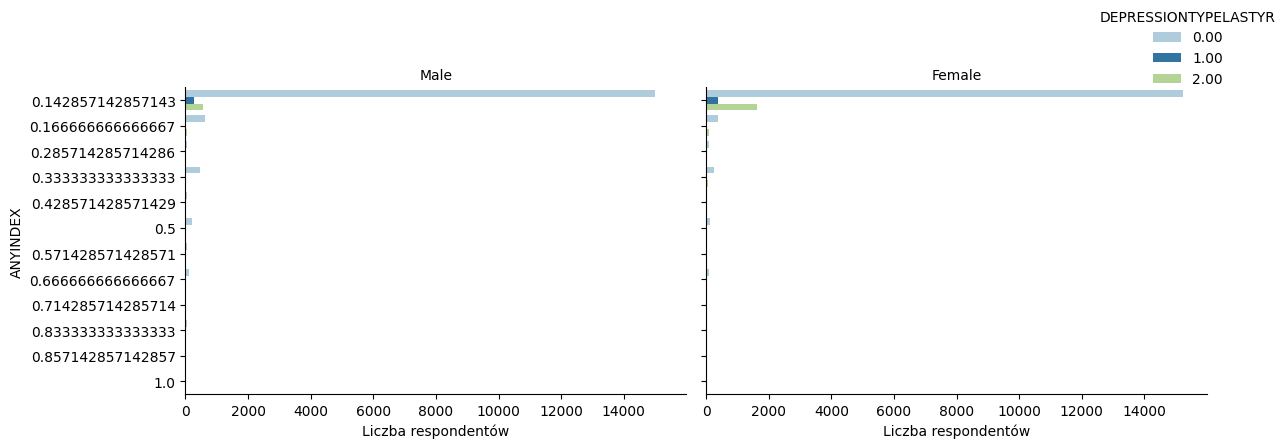

Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i wskaźnika uzależnienia od dowolnego narkotyku
DEPRESSIONTYPELASTYR      0    1     2  0_percentage  1_percentage  \
IRSEX_str ANYINDEX                                                   
Female    0.142857    15235  366  1626     88.436756      2.124572   
          0.166667      385   15    80     80.208333      3.125000   
          0.285714       91    4    32     71.653543      3.149606   
          0.333333      253   15    68     75.297619      4.464286   
          0.428571       38    8    20     57.575758     12.121212   
          0.500000      129   13    37     72.067039      7.262570   
          0.571429       36    3    22     59.016393      4.918033   
          0.666667       77    6    36     64.705882      5.042017   
          0.714286       18    1    19     47.368421      2.631579   
          0.833333       37    3    17     64.912281      5.263158   
          0.857143       16    3 

Text(0.5, 1.0, 'Procentowa liczba osób bez depresji w zależności od wskaźnika uzależnienia od dowolnego narkotyku')

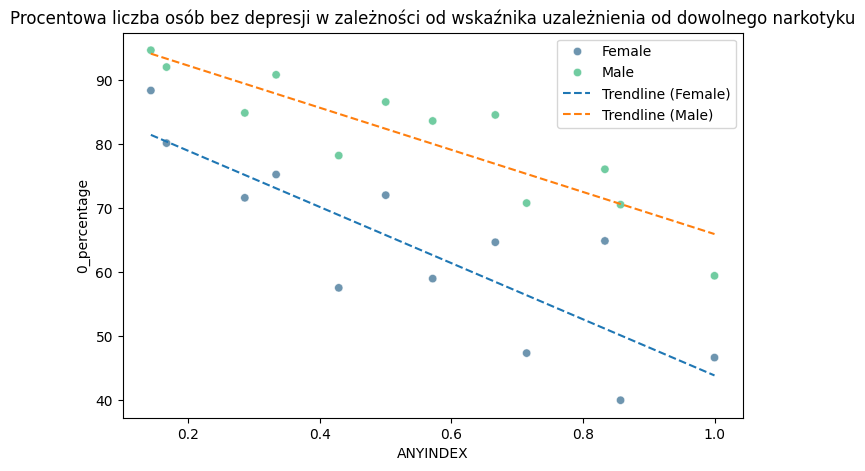

In [29]:
import numpy as np
g = sns.catplot(
    data=data_df,
    y='ANYINDEX',
    hue='DEPRESSIONTYPELASTYR',
    col='IRSEX_str',
    kind='count',
    palette='Paired',
    height=4,
    aspect=1.3,
    legend_out=True
)

for text in g._legend.texts:
    text.set_text(f"{float(text.get_text()):.2f}")
g._legend.set_bbox_to_anchor((1.05, 1))
g._legend.set_title("DEPRESSIONTYPELASTYR")

g.set_axis_labels("Liczba respondentów", "ANYINDEX")
g.set_titles("{col_name}")
g._legend.set_bbox_to_anchor((1.05, 1))

plt.tight_layout()
plt.show()

table_crosstab = pd.crosstab(
    index=[data_df['IRSEX_str'], data_df['ANYINDEX']],
    columns=data_df['DEPRESSIONTYPELASTYR']
)

table_crosstab_percentage = table_crosstab.div(table_crosstab.sum(axis=1), axis=0) * 100
table_crosstab = table_crosstab.join(table_crosstab_percentage, rsuffix='_percentage')

print("Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i wskaźnika uzależnienia od dowolnego narkotyku")
print(table_crosstab)

# Plot 0_percentage on y axis and ANYINDEX on x axis
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=table_crosstab.reset_index(),
    x='ANYINDEX',
    y='0_percentage',
    hue='IRSEX_str',
    palette='viridis',
    alpha=0.7,
)

# Add trendline
for sex in table_crosstab.reset_index()['IRSEX_str'].unique():
    subset = table_crosstab.reset_index()[table_crosstab.reset_index()['IRSEX_str'] == sex]
    z = np.polyfit(subset['ANYINDEX'], subset['0_percentage'], 1)
    p = np.poly1d(z)
    plt.plot(subset['ANYINDEX'], p(subset['ANYINDEX']), linestyle='--', label=f'Trendline ({sex})')

plt.legend()

plt.title('Procentowa liczba osób bez depresji w zależności od wskaźnika uzależnienia od dowolnego narkotyku')

Na podstawie wykersu widoczne jest, że wraz ze wzrostem wskaźnika uzależnienia od narkotyków, trend ilości osób bez depresji spada. Dodatkowo, dla każdej wartości wskaźnika ANYINDEX, wśród kobiet występował większy odsetek respodentów z depresją niż u mężczyzn.

DEPRESSIONTYPELASTYR      0    1     2
ANYCRIME_str                          
Crime                  2880  154   512
No crime              30118  639  2196


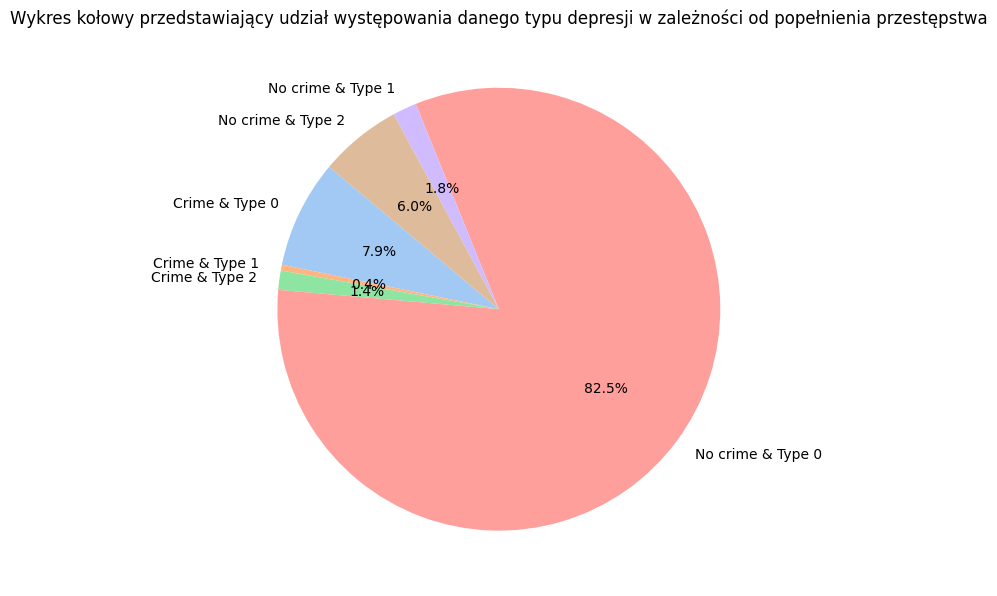

In [30]:
data_df['ANYCRIME'] = data_df['ANYCRIME'].astype(int)


crime_labels = {
    0: 'No crime',
    1: 'Crime'
}
data_df['ANYCRIME_str'] = data_df['ANYCRIME'].map(crime_labels)

table = pd.crosstab(data_df['ANYCRIME_str'], data_df['DEPRESSIONTYPELASTYR'])
print(table)
table_long = table.stack().reset_index()
table_long.columns = ['ANYCRIME_str', 'DEPRESSIONTYPELASTYR', 'Count']

table_long['Label'] = table_long.apply(
    lambda row: f"{row['ANYCRIME_str']} & Type {row['DEPRESSIONTYPELASTYR']}",
    axis=1
)


plt.figure(figsize=(7, 7))

values = table_long['Count']
labels = table_long['Label']

plt.pie(
    x=values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel', n_colors=len(values))
)

plt.title('Wykres kołowy przedstawiający udział występowania danego typu depresji w zależności od popełnienia przestępstwa')
plt.tight_layout()
plt.show()


Na podstawie powyższych wyników widać zależność pomiędzy popełnieniem przestępstwa a depresją, ponieważ ok. 19% osób, które popełniły przestępstwo miały depresję, a wśród respondetów, którzy odpowiedzieli, że nigdy nie popełnili przestępstwa odesetek ten wynosi ok 9%.

DEPRESSIONTYPELASTYR      0    1     2
CRIMEHIST_str                         
Crime                  4519  129   534
No crime              28479  664  2174


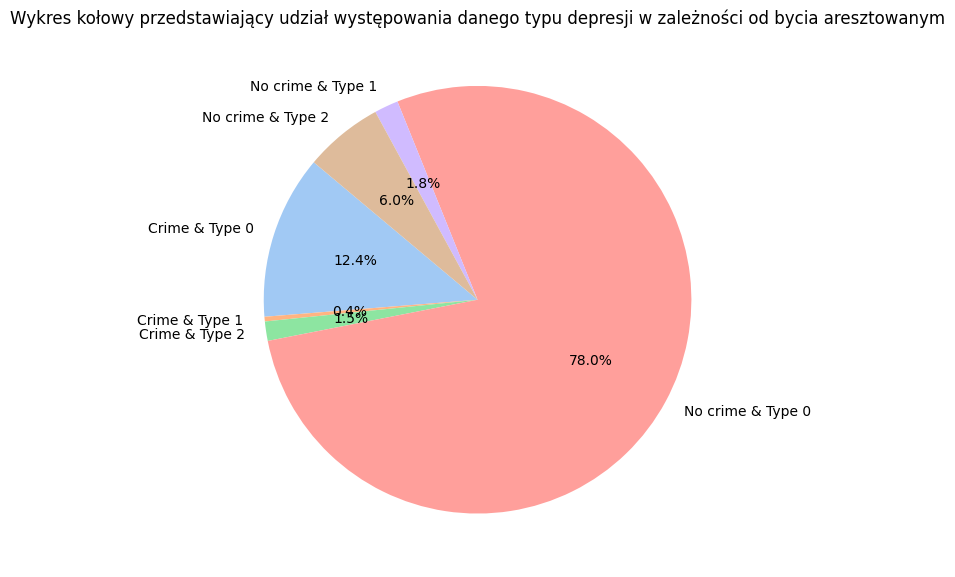

In [31]:
data_df['CRIMEHIST'] = data_df['CRIMEHIST'].astype(int)


crimehistory_labels = {
    0: 'No crime',
    1: 'Crime'
}
data_df['CRIMEHIST_str'] = data_df['CRIMEHIST'].map(crime_labels)

table = pd.crosstab(data_df['CRIMEHIST_str'], data_df['DEPRESSIONTYPELASTYR'])
print(table)
table_long = table.stack().reset_index()
table_long.columns = ['CRIMEHIST_str', 'DEPRESSIONTYPELASTYR', 'Count']

table_long['Label'] = table_long.apply(
    lambda row: f"{row['CRIMEHIST_str']} & Type {row['DEPRESSIONTYPELASTYR']}",
    axis=1
)


plt.figure(figsize=(7, 7))

values = table_long['Count']
labels = table_long['Label']

plt.pie(
    x=values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel', n_colors=len(values))
)

plt.title('Wykres kołowy przedstawiający udział występowania danego typu depresji w zależności od bycia aresztowanym')
plt.tight_layout()
plt.show()


Podobnie jak w przypadku popełnienia przestępstwa - bycie aresztowanym również zwiększa prawdopodobieństwo depresji.

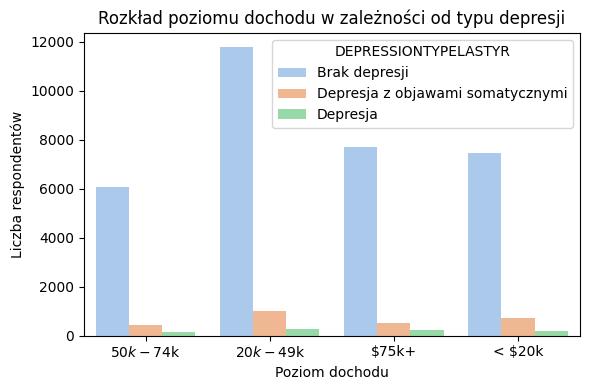

DEPRESSIONTYPELASTYR_str  Brak depresji  Depresja  \
INCOME_str                                          
$20k - $49k                       11766       259   
$50k - $74k                        6086       138   
$75k+                              7680       217   
< $20k                             7466       179   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi  \
INCOME_str                                                   
$20k - $49k                                           1017   
$50k - $74k                                            440   
$75k+                                                  509   
< $20k                                                 742   

DEPRESSIONTYPELASTYR_str  Brak depresji_percentage  Depresja_percentage  \
INCOME_str                                                                
$20k - $49k                              90.216225             1.985892   
$50k - $74k                              91.326531             2.070828   
$75k+   

In [32]:
income_labels = {
    1: '< $20k',
    2: '$20k - $49k',
    3: '$50k - $74k',
    4: '$75k+'
}

data_df['INCOME'] = data_df['INCOME'].astype(int)
data_df['INCOME_str'] = data_df['INCOME'].map(income_labels)

plt.figure(figsize=(6,4))
sns.countplot(
    data=data_df,
    x='INCOME_str',
    hue='DEPRESSIONTYPELASTYR_str',
    palette='pastel'
)
plt.title('Rozkład poziomu dochodu w zależności od typu depresji')
plt.xlabel('Poziom dochodu')
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.legend(title='DEPRESSIONTYPELASTYR', bbox_to_anchor=(1, 1))
plt.show()

table = pd.crosstab(data_df['INCOME_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

W przypadku dochodu rodziny, ogólny odsetek osób z depresją nieznacznie zmniejsza się, wraz z przejściem na wyższy poziom zarobków. Interesujący jest fakt, że większe zarobki powodują, że odsetek osób z depresją somatyczną jest mniejszy, ale udział "czystej" depresji wśród wszystkich mających depresję się zwiększa.

/tmp/ipykernel_167075/1393414511.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


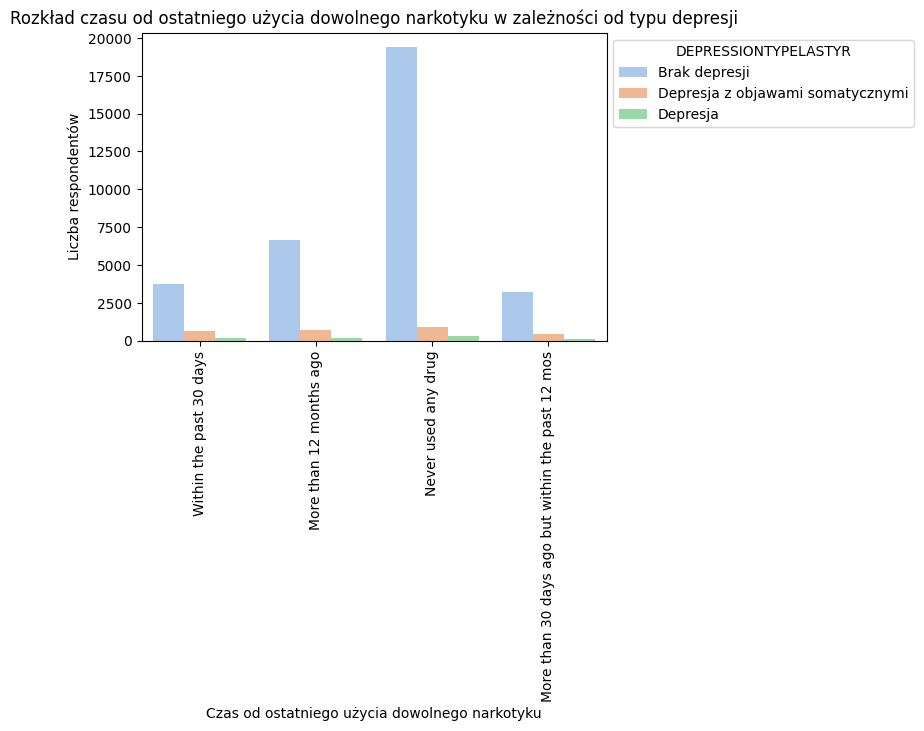

DEPRESSIONTYPELASTYR_str                          Brak depresji  Depresja  \
ANYILLICITRC_str                                                            
More than 12 months ago                                    6674       170   
More than 30 days ago but within the past 12 mos           3211       137   
Never used any drug                                       19389       322   
Within the past 30 days                                    3724       164   

DEPRESSIONTYPELASTYR_str                          Depresja z objawami somatycznymi  \
ANYILLICITRC_str                                                                     
More than 12 months ago                                                        733   
More than 30 days ago but within the past 12 mos                               437   
Never used any drug                                                            923   
Within the past 30 days                                                        615   

DEPRESSIONTYPELASTYR

In [33]:
recency_any_illicit_labels = {
    3: 'Within the past 30 days',
    2: 'More than 30 days ago but within the past 12 mos',
    1: 'More than 12 months ago',
    0: 'Never used any drug'
}

data_df['ANYILLICITRC'] = data_df['ANYILLICITRC'].astype(int)
data_df['ANYILLICITRC_str'] = data_df['ANYILLICITRC'].map(recency_any_illicit_labels)

plt.figure(figsize=(6,4))
sns.countplot(
    data=data_df,
    x='ANYILLICITRC_str',
    hue='DEPRESSIONTYPELASTYR_str',
    palette='pastel'
)
plt.title('Rozkład czasu od ostatniego użycia dowolnego narkotyku w zależności od typu depresji')
plt.xlabel('Czas od ostatniego użycia dowolnego narkotyku')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.legend(title='DEPRESSIONTYPELASTYR', bbox_to_anchor=(1, 1))
plt.show()

table = pd.crosstab(data_df['ANYILLICITRC_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')
print(table)

Na podstawie danych widoczne jest, że im mniej czasu minęło od użycia narkotyków, tym większy jest ogólny procent osób z depresją, z depresją "czystą" i depresją somatyczną.

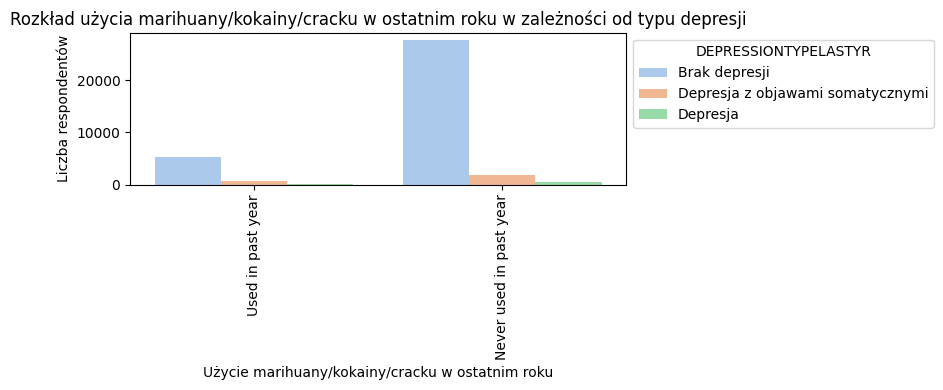

DEPRESSIONTYPELASTYR_str  Brak depresji  Depresja  \
MJCOKELY_str                                        
Never used in past year           27655       573   
Used in past year                  5343       220   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi  \
MJCOKELY_str                                                 
Never used in past year                               1937   
Used in past year                                      771   

DEPRESSIONTYPELASTYR_str  Brak depresji_percentage  Depresja_percentage  \
MJCOKELY_str                                                              
Never used in past year                  91.679098             1.899552   
Used in past year                        84.354278             3.473319   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi_percentage  
MJCOKELY_str                                                           
Never used in past year                                      6.421349  
Used in past year    

In [34]:
MJCOKELY_labels = {
    0: 'Never used in past year',
    1: 'Used in past year'
}

data_df['MJCOKELY'] = data_df['MJCOKELY'].astype(int)
data_df['MJCOKELY_str'] = data_df['MJCOKELY'].map(MJCOKELY_labels)

plt.figure(figsize=(6,4))
sns.countplot(
    data=data_df,
    x='MJCOKELY_str',
    hue='DEPRESSIONTYPELASTYR_str',
    palette='pastel'
)
plt.title('Rozkład użycia marihuany/kokainy/cracku w ostatnim roku w zależności od typu depresji')
plt.xlabel('Użycie marihuany/kokainy/cracku w ostatnim roku')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.legend(title='DEPRESSIONTYPELASTYR', bbox_to_anchor=(1, 1))
plt.show()

table = pd.crosstab(data_df['MJCOKELY_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

Podobnie jak w poprzednim porównaniu, użycie narkotyków powoduje, że więcej osób ma depresję jeżeli użyli w ostatnim roku narkotyków.

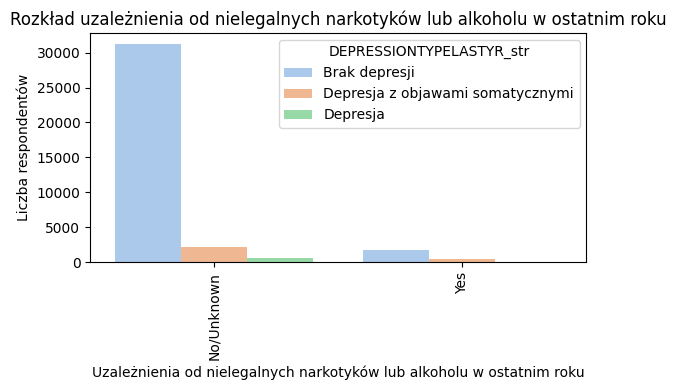

DEPRESSIONTYPELASTYR_str  Brak depresji  Depresja  \
DPILLALC_str                                        
No/Unknown                        31257       680   
Yes                                1741       113   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi  \
DPILLALC_str                                                 
No/Unknown                                            2227   
Yes                                                    481   

DEPRESSIONTYPELASTYR_str  Brak depresji_percentage  Depresja_percentage  \
DPILLALC_str                                                              
No/Unknown                               91.491043             1.990399   
Yes                                      74.561028             4.839400   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi_percentage  
DPILLALC_str                                                           
No/Unknown                                                   6.518558  
Yes                  

In [35]:
DPILLALC_labels = {
    0: 'No/Unknown',
    1: 'Yes'
}

data_df['DPILLALC'] = data_df['DPILLALC'].astype(int)
data_df['DPILLALC_str'] = data_df['DPILLALC'].map(DPILLALC_labels)

plt.figure(figsize=(6,4))
sns.countplot(
    data=data_df,
    x='DPILLALC_str',
    hue='DEPRESSIONTYPELASTYR_str',
    palette='pastel'
)
plt.title('Rozkład uzależnienia od nielegalnych narkotyków lub alkoholu w ostatnim roku')
plt.xlabel('Uzależnienia od nielegalnych narkotyków lub alkoholu w ostatnim roku')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['DPILLALC_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

W przypadku uzależnienia od alkoholu i narkotyków widoczna jest znaczna różnica. W przypadku osób uzależnionych ponad 25% miało epizod depresyjny, w porównaniu do ok. 9% wśród osób, które nie były w ostatnim roku uzależnione. Dodatkowo ponad 20% respondentów, którzy byli uzależnienie mieli depresję somatyczną.

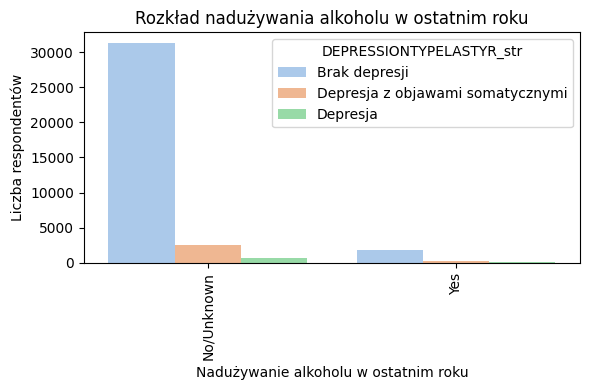

DEPRESSIONTYPELASTYR_str  Brak depresji  Depresja  \
ABUSEALC_str                                        
No/Unknown                        31239       735   
Yes                                1759        58   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi  \
ABUSEALC_str                                                 
No/Unknown                                            2494   
Yes                                                    214   

DEPRESSIONTYPELASTYR_str  Brak depresji_percentage  Depresja_percentage  \
ABUSEALC_str                                                              
No/Unknown                               90.631890             2.132413   
Yes                                      86.607582             2.855736   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi_percentage  
ABUSEALC_str                                                           
No/Unknown                                                   7.235697  
Yes                  

In [36]:
ABUSEALC_labels = {
    0: 'No/Unknown',
    1: 'Yes'
}

data_df['ABUSEALC'] = data_df['ABUSEALC'].astype(int)
data_df['ABUSEALC_str'] = data_df['ABUSEALC'].map(ABUSEALC_labels)

plt.figure(figsize=(6,4))
sns.countplot(
data=data_df,
x='ABUSEALC_str',
hue='DEPRESSIONTYPELASTYR_str',
palette='pastel'
)
plt.title('Rozkład nadużywania alkoholu w ostatnim roku')
plt.xlabel('Nadużywanie alkoholu w ostatnim roku')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['ABUSEALC_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

Ponownie widoczne jest, że korzystanie z używek (w tym przypadku nadużywanie alkoholu) powoduje zwiększenie procentowego udziału osób z depresją w danym zbiorze. Nie jest to aż tak drastyczny przeskok jak w poprzedniej analizie, jednak nadal różnica wynosi 4 punkty procentowe.

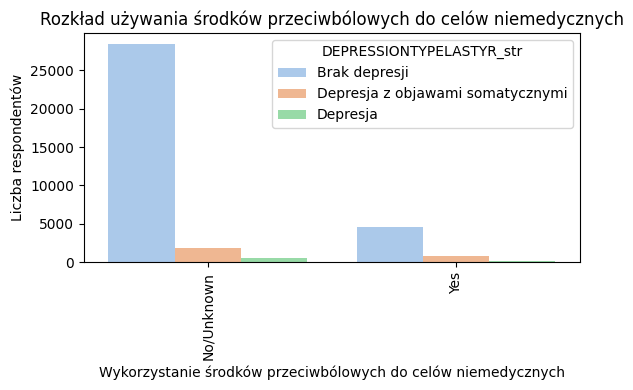

DEPRESSIONTYPELASTYR_str  Brak depresji  Depresja  \
ANLEVER_str                                         
No/Unknown                        28437       587   
Yes                                4561       206   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi  \
ANLEVER_str                                                  
No/Unknown                                            1861   
Yes                                                    847   

DEPRESSIONTYPELASTYR_str  Brak depresji_percentage  Depresja_percentage  \
ANLEVER_str                                                               
No/Unknown                               92.073822             1.900599   
Yes                                      81.243320             3.669398   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi_percentage  
ANLEVER_str                                                            
No/Unknown                                                   6.025579  
Yes                  

In [37]:
ANLEVER_labels = {
0: 'No/Unknown',
1: 'Yes'
}

data_df['ANLEVER'] = data_df['ANLEVER'].astype(int)
data_df['ANLEVER_str'] = data_df['ANLEVER'].map(ANLEVER_labels)

plt.figure(figsize=(6,4))
sns.countplot(
data=data_df,
x='ANLEVER_str',
hue='DEPRESSIONTYPELASTYR_str',
palette='pastel'
)
plt.title('Rozkład używania środków przeciwbólowych do celów niemedycznych')
plt.xlabel('Wykorzystanie środków przeciwbólowych do celów niemedycznych')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['ANLEVER_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

W przypadku badania czy ktoś wykorzystywał leki przeciwbólowe do celów niemedycznych następuje ponad 2-krotny wzrost udziału osób z depresją wśród osób, które te środki przeciwbólowe użyły, w porównaniu do osób, które tego nie robiły.

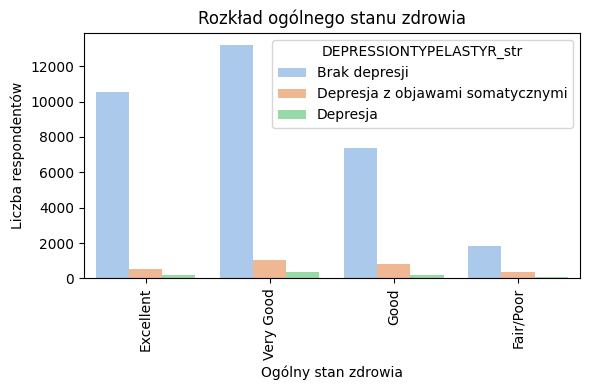

DEPRESSIONTYPELASTYR_str  Brak depresji  Depresja  \
HEALTH2_str                                         
Excellent                         10544       181   
Fair/Poor                          1846        56   
Good                               7376       212   
Very Good                         13232       344   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi  \
HEALTH2_str                                                  
Excellent                                              514   
Fair/Poor                                              349   
Good                                                   831   
Very Good                                             1014   

DEPRESSIONTYPELASTYR_str  Brak depresji_percentage  Depresja_percentage  \
HEALTH2_str                                                               
Excellent                                93.816176             1.610464   
Fair/Poor                                82.007996             2.487783   
Good    

In [38]:
HEALTH2_labels = {
1: 'Excellent',
2: 'Very Good',
3: 'Good',
4: 'Fair/Poor'
}

data_df['HEALTH2'] = data_df['HEALTH2'].astype(int)
data_df['HEALTH2_str'] = data_df['HEALTH2'].map(HEALTH2_labels)

plt.figure(figsize=(6,4))
sns.countplot(
data=data_df,
x='HEALTH2_str',
hue='DEPRESSIONTYPELASTYR_str',
palette='pastel'
)
plt.title('Rozkład ogólnego stanu zdrowia')
plt.xlabel('Ogólny stan zdrowia')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['HEALTH2_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

W przypadku stanu zdrowia widoczne jest, że wraz z pogarszaniem się zdrowia udział osób z depresją się zwiększa. Udział osób z depresją somatyczną w grupie osób o najlepszym stanie zdrowia jest prawie 4-krotnie niższy niż w grupie osób z najgorszym stanem zdrowia.

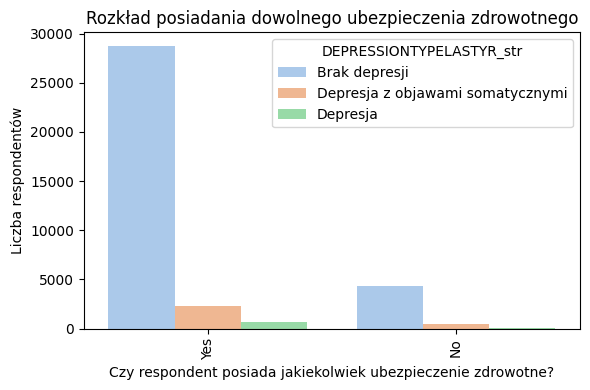

DEPRESSIONTYPELASTYR_str  Brak depresji  Depresja  \
ANYHLTI2_str                                        
No                                 4309        81   
Yes                               28689       712   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi  \
ANYHLTI2_str                                                 
No                                                     452   
Yes                                                   2256   

DEPRESSIONTYPELASTYR_str  Brak depresji_percentage  Depresja_percentage  \
ANYHLTI2_str                                                              
No                                       88.992152             1.672862   
Yes                                      90.624506             2.249108   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi_percentage  
ANYHLTI2_str                                                           
No                                                           9.334986  
Yes                  

In [39]:
ANYHLTI2_labels = {
1: 'Yes',
2: 'No'
}

data_df['ANYHLTI2'] = data_df['ANYHLTI2'].astype(int)
data_df['ANYHLTI2_str'] = data_df['ANYHLTI2'].map(ANYHLTI2_labels)

plt.figure(figsize=(6,4))
sns.countplot(
data=data_df,
x='ANYHLTI2_str',
hue='DEPRESSIONTYPELASTYR_str',
palette='pastel'
)
plt.title('Rozkład posiadania dowolnego ubezpieczenia zdrowotnego')
plt.xlabel('Czy respondent posiada jakiekolwiek ubezpieczenie zdrowotne?')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['ANYHLTI2_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)


Pomimo tego, że mogłoby się wydawać, że brak ubezpieczenia zdrowotnego mógłby powodować dodatkowy stres, to różnica w odsetku osób z depresją w grupie tych, którzy je posiadają, a tymi, którzy nie posiadają jest nieznaczna (ok. 1.6 punktu procentowego).

/tmp/ipykernel_167075/2586003244.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


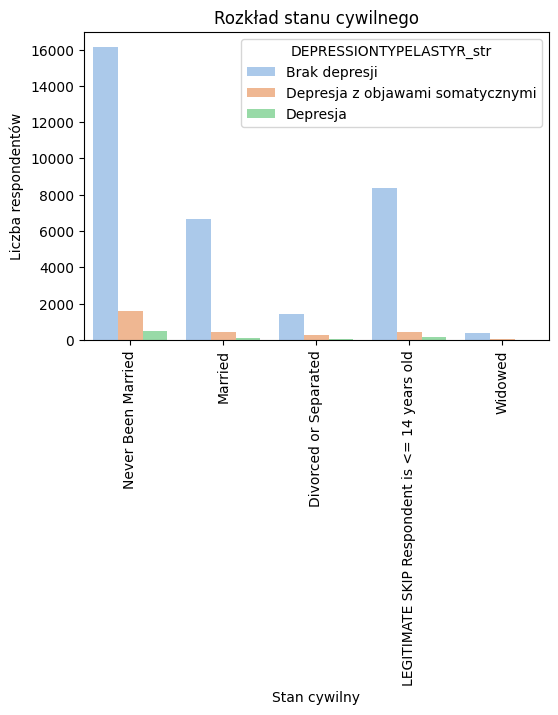

DEPRESSIONTYPELASTYR_str                       Brak depresji  Depresja  \
IRMARIT_str                                                              
Divorced or Separated                                   1400        30   
LEGITIMATE SKIP Respondent is <= 14 years old           8388       180   
Married                                                 6658        89   
Never Been Married                                     16167       490   
Widowed                                                  385         4   

DEPRESSIONTYPELASTYR_str                       Depresja z objawami somatycznymi  \
IRMARIT_str                                                                       
Divorced or Separated                                                       249   
LEGITIMATE SKIP Respondent is <= 14 years old                               431   
Married                                                                     415   
Never Been Married                                                

In [40]:
IRMARIT_labels = {
1: 'Married',
2: 'Widowed',
3: 'Divorced or Separated',
4: 'Never Been Married',
5: 'LEGITIMATE SKIP Respondent is <= 14 years old'
}

data_df['IRMARIT'] = data_df['IRMARIT'].astype(int)
data_df['IRMARIT_str'] = data_df['IRMARIT'].map(IRMARIT_labels)

plt.figure(figsize=(6,4))
sns.countplot(
data=data_df,
x='IRMARIT_str',
hue='DEPRESSIONTYPELASTYR_str',
palette='pastel'
)
plt.title('Rozkład stanu cywilnego')
plt.xlabel('Stan cywilny')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['IRMARIT_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)


Na podstawie stanu cywilnego można zauważyć, że najmniejszy odsetek osób z depresją jest w grupie, która nie może jeszcze zawrzeć małżeństwa ze względu na wiek, a następnie wśród osób żyjących w małżeństwie i rozwiedzionych. Wśród osób żyjących w separacji prawie 15% ma depresję somatyczną, co jest bardzo niepokojącą statystyką w porównaniu do innych grup.

/tmp/ipykernel_167075/4254536708.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


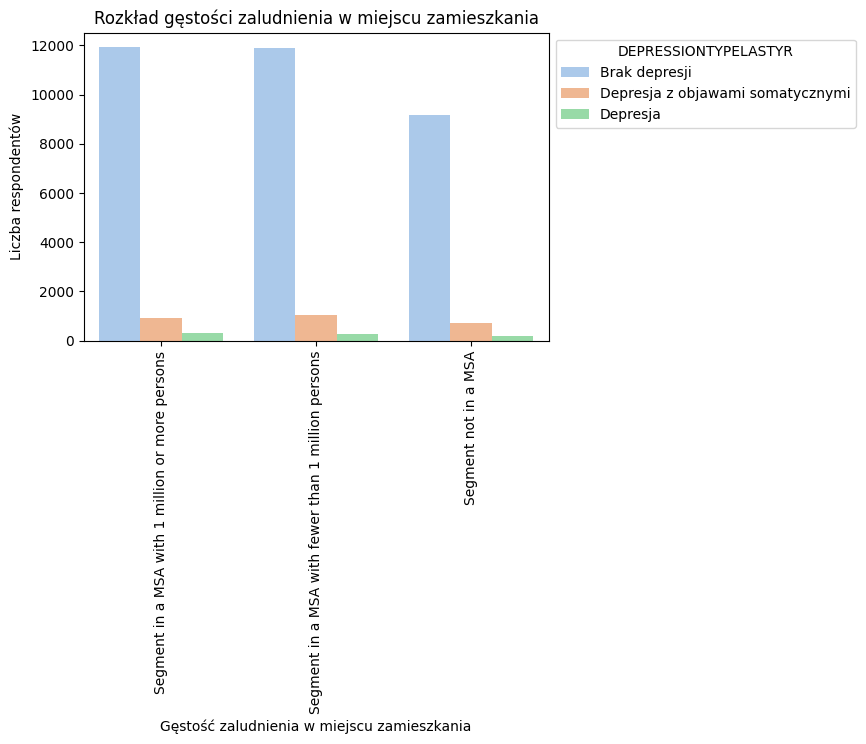

DEPRESSIONTYPELASTYR_str                            Brak depresji  Depresja  \
REVERSEPOP_str                                                                
Segment in a MSA with 1 million or more persons             11916       306   
Segment in a MSA with fewer than 1 million persons          11910       285   
Segment not in a MSA                                         9172       202   

DEPRESSIONTYPELASTYR_str                            Depresja z objawami somatycznymi  \
REVERSEPOP_str                                                                         
Segment in a MSA with 1 million or more persons                                  939   
Segment in a MSA with fewer than 1 million persons                              1034   
Segment not in a MSA                                                             735   

DEPRESSIONTYPELASTYR_str                            Brak depresji_percentage  \
REVERSEPOP_str                                                                 
Seg

In [41]:
REVERSEPOP_labels = {
1: 'Segment not in a MSA',
2: 'Segment in a MSA with fewer than 1 million persons',
3: 'Segment in a MSA with 1 million or more persons'
}

data_df['REVERSEPOP'] = data_df['REVERSEPOP'].astype(int)
data_df['REVERSEPOP_str'] = data_df['REVERSEPOP'].map(REVERSEPOP_labels)

plt.figure(figsize=(6,4))
sns.countplot(
data=data_df,
x='REVERSEPOP_str',
hue='DEPRESSIONTYPELASTYR_str',
palette='pastel'
)
plt.title('Rozkład gęstości zaludnienia w miejscu zamieszkania')
plt.xlabel('Gęstość zaludnienia w miejscu zamieszkania')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.legend(title='DEPRESSIONTYPELASTYR', bbox_to_anchor=(1, 1))
plt.show()

table = pd.crosstab(data_df['REVERSEPOP_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)


Na podstawie wykresów gęstości zaludnienia w miejscu zamieszkania nie można wnioskować o wpływie na depresję, ponieważ różnice są bardzo nieznaczne w porównaniu do wcześniejszych cech.

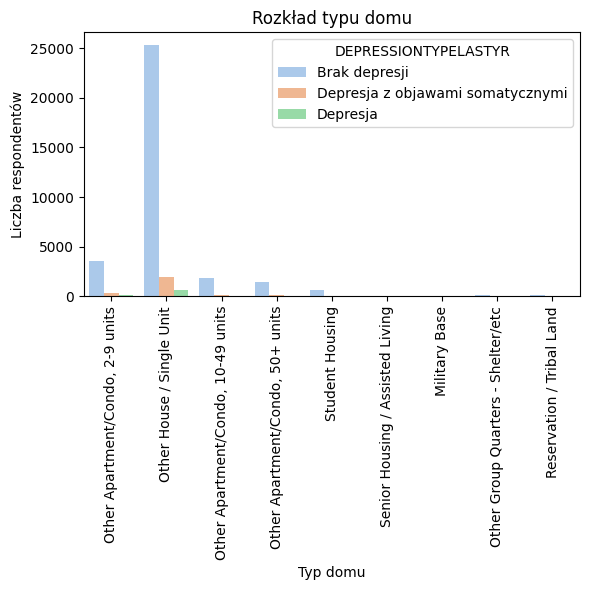

DEPRESSIONTYPELASTYR_str            Brak depresji  Depresja  \
CACHAR_str                                                    
Military Base                                  51         0   
Other Apartment/Condo, 10-49 units           1851        39   
Other Apartment/Condo, 2-9 units             3514        78   
Other Apartment/Condo, 50+ units             1430        27   
Other Group Quarters - Shelter/etc             85         3   
Other House / Single Unit                   25344       620   
Reservation / Tribal Land                      91         2   
Senior Housing / Assisted Living               47         1   
Student Housing                               585        23   

DEPRESSIONTYPELASTYR_str            Depresja z objawami somatycznymi  \
CACHAR_str                                                             
Military Base                                                      5   
Other Apartment/Condo, 10-49 units                               158   
Other Apartment/Co

In [42]:
CACHAR_labels = {
1: 'Military Base',
2: 'Student Housing',
3: 'Reservation / Tribal Land',
4: 'Other Group Quarters - Shelter/etc',
5: 'Senior Housing / Assisted Living',
6: 'Other House / Single Unit',
7: 'Other Apartment/Condo, 2-9 units',
8: 'Other Apartment/Condo, 10-49 units',
9: 'Other Apartment/Condo, 50+ units'
}

data_df['CACHAR'] = data_df['CACHAR'].astype(int)
data_df['CACHAR_str'] = data_df['CACHAR'].map(CACHAR_labels)

plt.figure(figsize=(6,6))
sns.countplot(
data=data_df,
x='CACHAR_str',
hue='DEPRESSIONTYPELASTYR_str',
palette='pastel'
)
plt.title('Rozkład typu domu')
plt.xlabel('Typ domu')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.legend(title='DEPRESSIONTYPELASTYR', bbox_to_anchor=(1, 1))
plt.show()

table = pd.crosstab(data_df['CACHAR_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)


Podobnie jak w przypadku analizy gęstości zaludnienia w miejscu zamieszkania, przy porównywaniu typu miejsca zamieszkania trudno jest znaleźć znaczne różnice. Porównania też mogłyby być problematyczne ze względu na duże różnice w liczebności poszczególnych podgrup. Interesujący jest fakt, że żaden żołnierz biorący udział w badaniu nie miał "czystej" depresji.

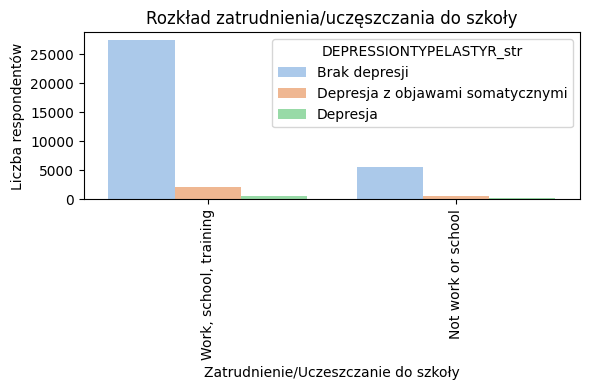

DEPRESSIONTYPELASTYR_str  Brak depresji  Depresja  \
WORKSCHOOL_str                                      
Not work or school                 5555       170   
Work, school, training            27443       623   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi  \
WORKSCHOOL_str                                               
Not work or school                                     643   
Work, school, training                                2065   

DEPRESSIONTYPELASTYR_str  Brak depresji_percentage  Depresja_percentage  \
WORKSCHOOL_str                                                            
Not work or school                       87.233040             2.669598   
Work, school, training                   91.078955             2.067638   

DEPRESSIONTYPELASTYR_str  Depresja z objawami somatycznymi_percentage  
WORKSCHOOL_str                                                         
Not work or school                                          10.097362  
Work, school, trainin

In [43]:
WORKSCHOOL_labels = {
1: 'Work, school, training',
2: 'Not work or school'
}

data_df['WORKSCHOOL'] = data_df['WORKSCHOOL'].astype(int)
data_df['WORKSCHOOL_str'] = data_df['WORKSCHOOL'].map(WORKSCHOOL_labels)

plt.figure(figsize=(6,4))
sns.countplot(
data=data_df,
x='WORKSCHOOL_str',
hue='DEPRESSIONTYPELASTYR_str',
palette='pastel'
)
plt.title('Rozkład zatrudnienia/uczęszczania do szkoły')
plt.xlabel('Zatrudnienie/Uczeszczanie do szkoły')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['WORKSCHOOL_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

W przypadku podziału na osoby, które uczęszczają do szkoły lub pracują, a takie, które tego nie robią, występuje różnica 4 punktów procentowych w udziale osób z depresją, gdzie większą część stanowią wśród osób bez pracy/nie chodzących do szkoły. Uzasadnienie tego faktu może być takie, że osoby, które nie pracują, a chcą to robić są tym faktem bardziej zestresowane i bardziej to na nie wpływa niż stres, który jest na osobach pracujących.

/tmp/ipykernel_167075/2822566924.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


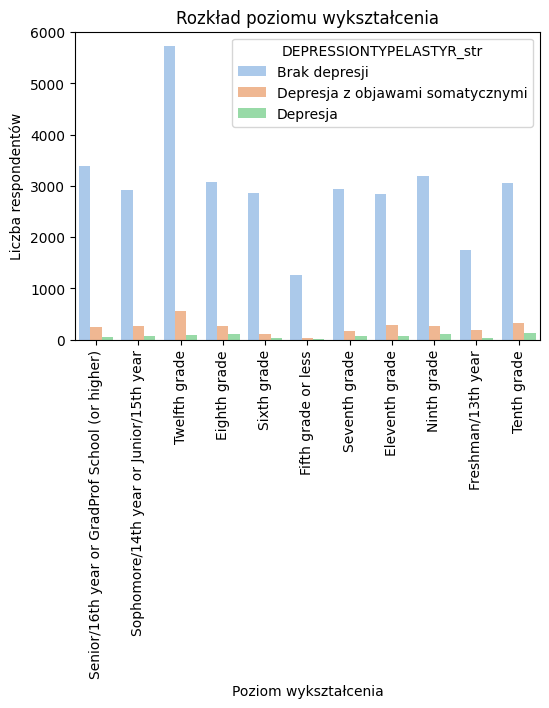

DEPRESSIONTYPELASTYR_str                         Brak depresji  Depresja  \
IREDUC2_str                                                                
Eighth grade                                              3083       110   
Eleventh grade                                            2833        79   
Fifth grade or less                                       1254        13   
Freshman/13th year                                        1750        35   
Ninth grade                                               3200       108   
Senior/16th year or GradProf School (or higher)           3388        56   
Seventh grade                                             2937        69   
Sixth grade                                               2855        37   
Sophomore/14th year or Junior/15th year                   2914        70   
Tenth grade                                               3058       125   
Twelfth grade                                             5726        91   

DEPRESSIONT

In [44]:
IREDUC2_labels = {
    1: 'Fifth grade or less',
    2: 'Sixth grade',
    3: 'Seventh grade',
    4: 'Eighth grade',
    5: 'Ninth grade',
    6: 'Tenth grade',
    7: 'Eleventh grade',
    8: 'Twelfth grade',
    9: 'Freshman/13th year',
    10: 'Sophomore/14th year or Junior/15th year',
    11: 'Senior/16th year or GradProf School (or higher)'
}

data_df['IREDUC2'] = data_df['IREDUC2'].astype(int)
data_df['IREDUC2_str'] = data_df['IREDUC2'].map(IREDUC2_labels)

plt.figure(figsize=(6,4))
sns.countplot(
data=data_df,
x='IREDUC2_str',
hue='DEPRESSIONTYPELASTYR_str',
palette='pastel'
)
plt.title('Rozkład poziomu wykształcenia')
plt.xlabel('Poziom wykształcenia')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['IREDUC2_str'], data_df['DEPRESSIONTYPELASTYR_str'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

Analizując poziom wykształcenia widoczne jest, że najmniejszy udział osób z depresją jest w grupie o wykształceniu maksymalnie 5 klasy, następnie aż do 10 klasy odsetek osób z depresją rośnie, a następnie powoli spada aż do poziomu z okolic 7 klasy. Większość poziomów edukacji z najwyższym odsetkiem osób z depresją przypada na klasy w `High School`.

## Wybór cech do modelu

W poprzedniej części cechy zostały pojedynczo sprawdzone i przeanalizowane, a w tej części obliczona zostanie wartość bezwzględna korelacji każdej cechy z `MDEYR`. Wartość bezwzględna zostanie wykorzystana, ponieważ ujemna wartość korelacji nie wskazuje na brak korelacji, a na wpływ wartości z przeciwnym znakiem. Następnie, zaczynając od cechy z największą wartością bezwzględnej korelacji, sprawdzone zostanie, czy wybrana cecha jest istotnie różna, od cech, które zostały wcześniej wybrane. Dodatkowo dla `CACHAR`, `IRMARIT` i `NEWRACE2` zastosowany został one-hot encoding, ponieważ wartości w tych kolumnach nie mogą być sortowane, więc rozbicie wartości na więcej kolumn powinno ułatwić modelowi zrozumienie danych.

Dodatkowo przeprowadzona zostanie normalizacja, aby wszystkie cechy mieściły się w zakresie 0-1.

W celu uniknięcia błędu wynikającego ze sprawdzania związku dla całego zbioru, a następnie uczeniu na jedynie jego części, przed przeprowadzeniem analizy wprowadzony zostanie podział na zbiór treningowy i walidacyjny w stosunku 85:15. Dodatkowo wykorzystana zostanie opcja `stratify`, aby zbiór treningowy i walidacyjny posiadał jednakowy udział osób z poszczególnym rodzajem depresji, a także ustawiony zostanie `random_state`, aby wyniki były powtarzalne.

In [45]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(data_df[['CACHAR', 'NEWRACE2', 'IRMARIT']]).toarray()
encoded_columns = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['CACHAR', 'NEWRACE2', 'IRMARIT']))

data_df = pd.concat([data_df, encoded_columns], axis=1)

columns_to_use_after_encoding = columns_to_use + encoded_columns.columns.to_list()
columns_to_use_after_encoding.remove('CACHAR')
columns_to_use_after_encoding.remove('NEWRACE2')
columns_to_use_after_encoding.remove('IRMARIT')
print(columns_to_use_after_encoding)

['MDEYR', 'DEPRESSIONTYPELASTYR', 'IRSEX', 'CATAG7', 'ANYINDEX', 'ANYILLICITRC', 'MJCOKELY', 'ANLEVER', 'ANYCRIME', 'CRIMEHIST', 'WORKSCHOOL', 'IREDUC2', 'HEALTH2', 'ANYHLTI2', 'INCOME', 'DPILLALC', 'ABUSEALC', 'REVERSEPOP', 'CACHAR_1', 'CACHAR_2', 'CACHAR_3', 'CACHAR_4', 'CACHAR_5', 'CACHAR_6', 'CACHAR_7', 'CACHAR_8', 'CACHAR_9', 'NEWRACE2_1', 'NEWRACE2_2', 'NEWRACE2_3', 'NEWRACE2_4', 'NEWRACE2_5', 'NEWRACE2_6', 'NEWRACE2_7', 'IRMARIT_1', 'IRMARIT_2', 'IRMARIT_3', 'IRMARIT_4', 'IRMARIT_5']


In [46]:
# Normalize the data with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = columns_to_use_after_encoding.copy()
columns_to_scale.remove('DEPRESSIONTYPELASTYR')
data_df[columns_to_scale] = scaler.fit_transform(data_df[columns_to_scale])

In [47]:
from sklearn.model_selection import train_test_split

X = data_df[columns_to_use_after_encoding].copy()
y = data_df['MDEYR'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

Sprawdzenie jak wygląda rozkład wartości w poszczególnych kolumnach po podziale na zbiór treningowy i walidacyjny.

In [48]:
print(X_train.describe())

              MDEYR  DEPRESSIONTYPELASTYR         IRSEX        CATAG7  \
count  31024.000000          31024.000000  31024.000000  31024.000000   
mean       0.095926              0.169675      0.486333      0.475025   
std        0.294494              0.537023      0.499821      0.346796   
min        0.000000              0.000000      0.000000      0.000000   
25%        0.000000              0.000000      0.000000      0.166667   
50%        0.000000              0.000000      0.000000      0.500000   
75%        0.000000              0.000000      1.000000      0.833333   
max        1.000000              2.000000      1.000000      1.000000   

           ANYINDEX  ANYILLICITRC      MJCOKELY       ANLEVER      ANYCRIME  \
count  31024.000000  31024.000000  31024.000000  31024.000000  31024.000000   
mean       0.026291      0.260970      0.172544      0.153623      0.096893   
std        0.113366      0.351491      0.377859      0.360593      0.295816   
min        0.000000      0

In [49]:
print(X_val.describe())

             MDEYR  DEPRESSIONTYPELASTYR        IRSEX       CATAG7  \
count  5475.000000           5475.000000  5475.000000  5475.000000   
mean      0.095890              0.172603     0.484201     0.471781   
std       0.294468              0.544325     0.499796     0.342983   
min       0.000000              0.000000     0.000000     0.000000   
25%       0.000000              0.000000     0.000000     0.166667   
50%       0.000000              0.000000     0.000000     0.500000   
75%       0.000000              0.000000     1.000000     0.666667   
max       1.000000              2.000000     1.000000     1.000000   

          ANYINDEX  ANYILLICITRC     MJCOKELY      ANLEVER     ANYCRIME  \
count  5475.000000   5475.000000  5475.000000  5475.000000  5475.000000   
mean      0.026824      0.265875     0.179178     0.154886     0.098630   
std       0.111784      0.356171     0.383536     0.361829     0.298192   
min       0.000000      0.000000     0.000000     0.000000     0.0000

Widoczne jest, że wartości średnie i odchylenie standardowe każdej cechy są zbliżone w obu podzbiorach. Jest to dobra informacja, bo oznacza, że zbiór treningowy powinien dobrze odzwierciedlać zbiór walidacyjny.

<Axes: >

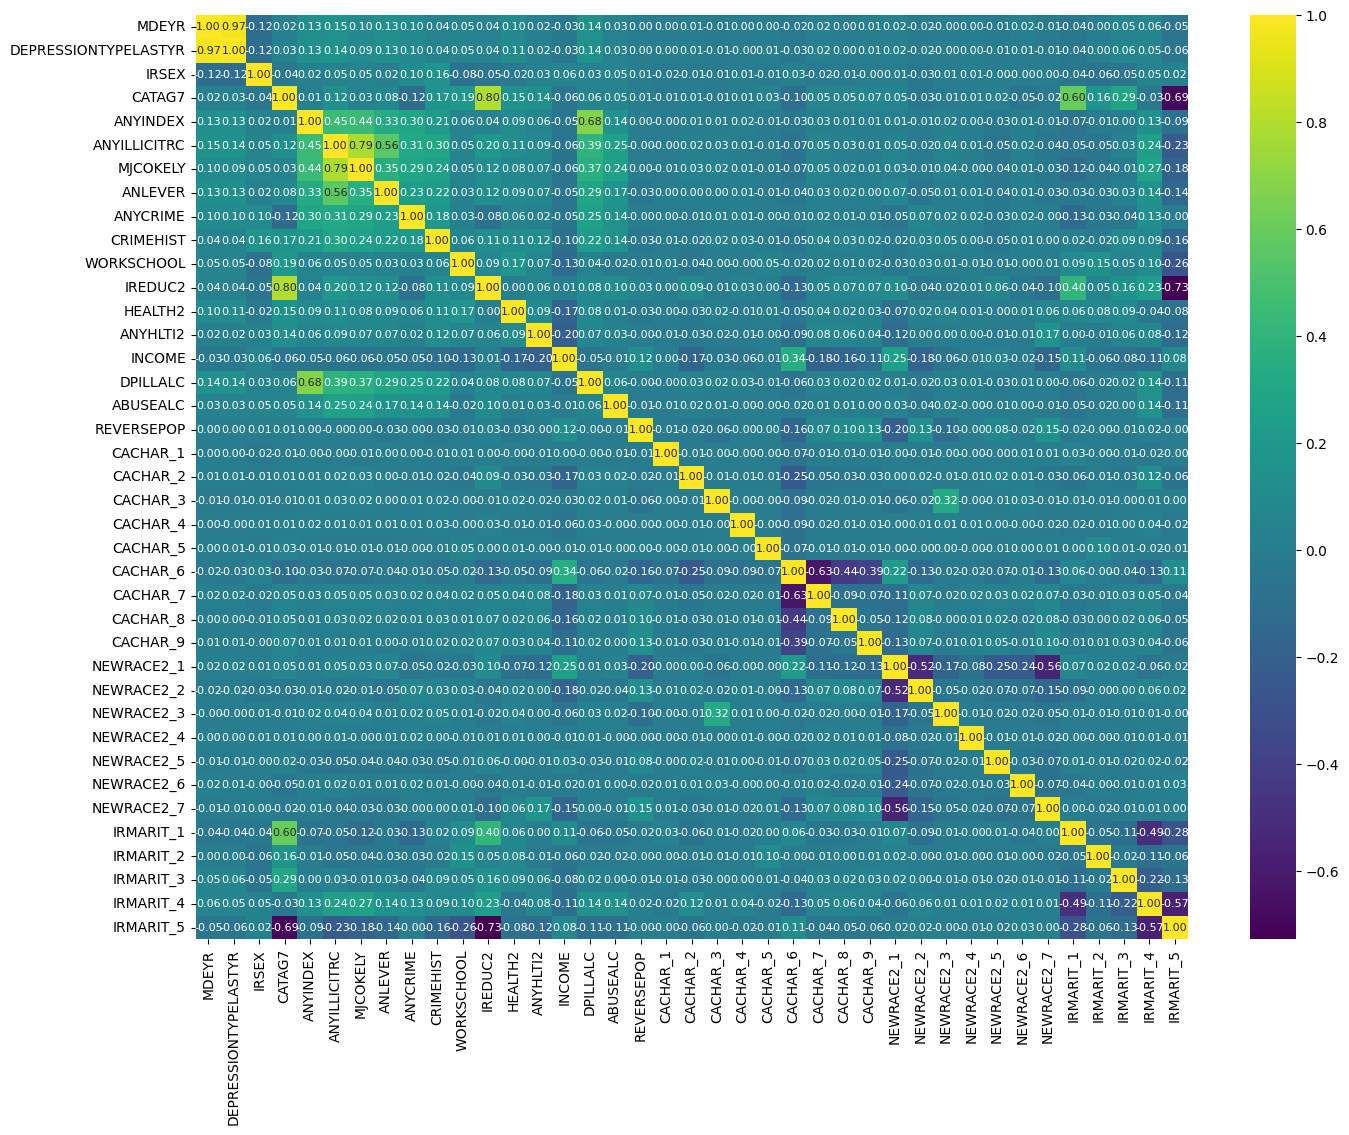

In [50]:
corr_matrix = X_train.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(
    data=corr_matrix,
    annot=True,
    cmap='viridis',
    fmt=".2f",
    annot_kws={'size': 8}
)

In [51]:
corr_values = corr_matrix.abs().unstack().sort_values(ascending=False)
corr_values = corr_values['MDEYR'].drop('MDEYR')
corr_values = corr_values.drop('DEPRESSIONTYPELASTYR')
print(corr_values)

ANYILLICITRC    0.146159
DPILLALC        0.142273
ANYINDEX        0.134427
ANLEVER         0.133808
IRSEX           0.115699
HEALTH2         0.102244
ANYCRIME        0.099033
MJCOKELY        0.095161
IRMARIT_4       0.059620
IRMARIT_5       0.054796
WORKSCHOOL      0.051327
IRMARIT_3       0.051103
IRMARIT_1       0.043069
CRIMEHIST       0.040897
IREDUC2         0.035586
ABUSEALC        0.029759
INCOME          0.028623
CACHAR_6        0.022512
NEWRACE2_1      0.019127
NEWRACE2_2      0.018395
CACHAR_7        0.018080
CATAG7          0.017988
ANYHLTI2        0.016813
NEWRACE2_6      0.015590
CACHAR_2        0.013025
NEWRACE2_5      0.011048
CACHAR_9        0.010352
NEWRACE2_7      0.009882
CACHAR_3        0.007120
CACHAR_5        0.004516
NEWRACE2_3      0.003331
REVERSEPOP      0.003084
NEWRACE2_4      0.002293
IRMARIT_2       0.001817
CACHAR_8        0.000845
CACHAR_4        0.000703
CACHAR_1        0.000556
dtype: float64


Na podstawie macierzy korelacji można zauważyć duże powiązanie depresji z cechami związanych z narkotykami (3 na pierwsze 4 pozycje), a najmniejszą związane z typem mieszkania (4 na ostatnie 5 miejsc).

Następnym krokiem jest znalezienie kolumn, które wykorzystane zostaną do treningu modelu. W tym celu sprawdzone zostanie, czy wykorzystane kolumny są istotnie różne. Wykorzystany zostanie do tego testu permutacyjny, a także sprawdzona zostanie wartość korelacji pomiędzy modelami.

In [52]:
from scipy.stats import permutation_test
from tqdm import tqdm

selected_columns = []

alpha = 0.05

def statistic(x, y):
    return np.mean(x) - np.mean(y)

for column_name in tqdm(corr_values.index, desc="Sprawdzenie czy kolumny są istotnie różne"):
    if len(selected_columns) == 0:
        selected_columns.append(column_name)
        continue

    different = True
    for selected_column in selected_columns:
        p_value = permutation_test(
            (X_train[selected_column].values,
            X_train[column_name].values),
            statistic,
            alternative='two-sided',
            n_resamples=123,
            rng=42
        )

        if p_value.pvalue > alpha:
            different = False
            break

        if abs(corr_matrix.loc[selected_column, column_name]) > 0.5:
            different = False
            break

    if different:
        selected_columns.append(column_name)



Sprawdzenie czy kolumny są istotnie różne: 100%|██████████| 37/37 [00:47<00:00,  1.28s/it]


In [53]:
print(selected_columns)

['ANYILLICITRC', 'DPILLALC', 'IRSEX', 'HEALTH2', 'ANYCRIME', 'IRMARIT_4', 'WORKSCHOOL', 'IRMARIT_3', 'IRMARIT_1', 'CRIMEHIST', 'IREDUC2', 'ABUSEALC', 'INCOME', 'CACHAR_6', 'NEWRACE2_1', 'ANYHLTI2', 'NEWRACE2_6', 'CACHAR_2', 'CACHAR_3', 'CACHAR_5', 'NEWRACE2_3', 'NEWRACE2_4', 'IRMARIT_2']


In [54]:
print("Liczba istotnie różnych kolumn:", len(selected_columns))
print("Łączna liczba kolumns:", len(corr_values.index))

Liczba istotnie różnych kolumn: 23
Łączna liczba kolumns: 37


Przeprowadzone testy permutacyjne pozwoliły na wyodrębnienie 23 istotnie różnych kolumn. Wynik mógłby się różnić przy wykorzystaniu większej liczby `n_resamples`, ale przyjęta wartość pozwala na wykonanie wszystkich testów w okolicę minuty.

Zdecydowałem, że wszystkie cechy pozostaną w liście, a w następnym kroku będą losowane kombinacje kolumn, aby znaleźć takie cechy, które dadzą najlepsze dopasowanie modelu do zbioru walidacyjnego.

## Model regresyjny do oceny ryzyka depresji

### Trening i wybór modelu

W tej części utworzony zostanie model regresyjny do oceny prawdopodobieństwa wystąpienia depresji. Ze względu na fakt, że kolumna `MDEYR` posiada wartości binarne (u respondenta wystąpił lub nie wystąpił silny epizod depresyjny), to wykorzystany zostanie próg `thres`, a wartości powyżej tego progu oznaczać będą wystąpienie epizodu depresyjnego, a poniżej jego brak. Dodatkowo dla każdego modelu wartość progu będzie dostosowywana (będzie sprawdzane 20 różnych wartości progu z zakresu `0.1 - 0.2` - zakres został zmniejszony w wyniku licznych testów, w których wychodziło, że przeszukiwanie poza tym zakresem jest w większości przypadków bezsensowne, a jedynie zabiera czas), aby znaleźć próg dający najwyższą wartość sumy wskaźników `'accuracy' + 'recall'`. 

Utworzonych zostanie wiele modeli, a cechy będą losowo wybierane ze zbioru uzyskanego na koniec poprzedniej części. Modele zostaną przetestowane na zbiorze treningowym, a model, który uzyska najwyższą wartość sumy wskaźników `'accuracy' + 'recall'`, zostanie wybrany do następnych etapów analizy. Wybór ten jest uzasadniony faktem, że osoby z depresją stanowią mniejszość w zbiorze danych, więc wysoki wynik `accuracy` jest możliwy przy zaklasyfikowaniu wszystkich jako `0`, dodatkowo istotne jest, żeby nie pominąć nikogo z depresją, więc wskaźnik `recall` powinien być jak najwyższy.

In [55]:
import statsmodels.api as sm
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score

from sklearn.metrics import r2_score

r2_values = []
np.random.seed(42)

models_with_results = []

num_of_models = 200

for _ in tqdm(range(num_of_models), desc=f"Obliczanie wyników dla {num_of_models} modeli"):
    columns_for_model = np.random.choice(selected_columns, np.random.randint(6, 14), replace=False)
    X_train_model = X_train[columns_for_model].copy()
    # X_train_model = sm.add_constant(X_train_model)
    model = sm.OLS(y_train, X_train_model).fit()
    y_pred = model.predict(X_train_model)

    best_result = 0
    best_f1 = 0
    best_thres = 0
    best_accuracy = 0
    best_recall = 0
    best_precision = 0
    best_roc_auc = 0

    for i in range(20):
        y_pred_class = (y_pred > (0.1 + i / 200)).astype(int)
        accuracy = accuracy_score(y_train, y_pred_class)
        recall = recall_score(y_train, y_pred_class)
        precision = precision_score(y_train, y_pred_class)
        f1 = f1_score(y_train, y_pred_class)
        roc_auc = roc_auc_score(y_train, y_pred_class)

        result = accuracy + recall

        if result > best_result:
            best_f1 = f1
            best_thres = 0.1 + i / 200
            best_accuracy = accuracy
            best_recall = recall
            best_precision = precision
            best_roc_auc = roc_auc
            best_result = result

    r2 = r2_score(y_train, y_pred)

    models_with_results.append({
        'columns': columns_for_model,
        'accuracy': best_accuracy,
        'recall': best_recall,
        'precision': best_precision,
        'f1': best_f1,
        'roc_auc': best_roc_auc,
        'r2': r2,
        'threshold': best_thres
    })

Obliczanie wyników dla 200 modeli:  20%|█▉        | 39/200 [00:09<00:39,  4.05it/s]/home/marcin/Documents/GitHub/Gender-Mental-Illness-and-Crime-in-the-United-States-Analysis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marcin/Documents/GitHub/Gender-Mental-Illness-and-Crime-in-the-United-States-Analysis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Obliczanie wyników dla 200 modeli:  50%|█████     | 100/200 [00:24<00:24,  4.06it/s]/home/marcin/Documents/GitHub/Gender-Ment

Poniżej wypisane zostały modele, które otrzymaly największą sumę metryk `recall` i `accuracy`

In [56]:
models_with_results_sorted = sorted(models_with_results, key=lambda x: x['recall'] + x['accuracy'], reverse=True)
for index, model in enumerate(models_with_results_sorted[:5]):
    print("Model", index + 1)
    print("Suma recall i accuracy:", model['recall'] + model['accuracy'])
    print("Kolumny:", model['columns'])
    print("Accuracy:", model['accuracy'])
    print("Recall:", model['recall'])
    print("Precision:", model['precision'])
    print("F1:", model['f1'])
    print("ROC AUC:", model['roc_auc'])
    print("R^2:", model['r2'])
    print("Threshold:", model['threshold'])
    print("-" * 50)
    #print(model)

Model 1
Suma recall i accuracy: 1.3179588331198322
Kolumny: ['DPILLALC' 'NEWRACE2_6' 'NEWRACE2_4' 'NEWRACE2_1' 'IRMARIT_4'
 'NEWRACE2_3' 'ANYILLICITRC' 'ANYCRIME' 'IRSEX' 'CRIMEHIST' 'HEALTH2'
 'IREDUC2']
Accuracy: 0.6365072202166066
Recall: 0.6814516129032258
Precision: 0.16411750424860402
F1: 0.2645274897280376
ROC AUC: 0.6565950306387207
R^2: 0.053205112620074435
Threshold: 0.1
--------------------------------------------------
Model 2
Suma recall i accuracy: 1.2931816228296373
Kolumny: ['IRMARIT_1' 'NEWRACE2_4' 'IRSEX' 'CACHAR_2' 'CACHAR_6' 'WORKSCHOOL'
 'HEALTH2' 'INCOME' 'IRMARIT_3' 'ANYILLICITRC' 'ANYCRIME']
Accuracy: 0.6265149561629706
Recall: 0.6666666666666666
Precision: 0.15772318944272198
F1: 0.255094824815172
ROC AUC: 0.6444606864422893
R^2: 0.04534966145835362
Threshold: 0.1
--------------------------------------------------
Model 3
Suma recall i accuracy: 1.2900328292490864
Kolumny: ['WORKSCHOOL' 'CACHAR_3' 'CACHAR_6' 'IRSEX' 'NEWRACE2_1' 'ANYILLICITRC'
 'HEALTH2' 'IREDU

Jak widać, model wybrany poprzez sumę `recall` i `accuracy` posiada również najwyższą wartość metryk `R^2` i `ROS AUC` pośród top5 modeli. Dodatkowo posiada najwyższą wartość `recall`, co oznacza, że "pomija" najmniej osób z depresją.

Możemy sprawdzić jakie cechy występują najczęściej w powyższych modelach

In [57]:
columns_frequency = {}
for model in models_with_results_sorted[:5]:
    for column in model['columns']:
        if column not in columns_frequency:
            columns_frequency[column] = 1
        else:
            columns_frequency[column] += 1

columns_frequency = dict(sorted(columns_frequency.items(), key=lambda x: x[1], reverse=True))
print("Najczęściej występujące kolumny w top 5 modelach:")
print("Cecha: Liczba wystąpień")
for column, frequency in columns_frequency.items():
    print(f"{column}: {frequency}")

Najczęściej występujące kolumny w top 5 modelach:
Cecha: Liczba wystąpień
ANYILLICITRC: 5
IRSEX: 5
HEALTH2: 5
ANYCRIME: 4
INCOME: 4
DPILLALC: 3
NEWRACE2_1: 3
IREDUC2: 3
IRMARIT_1: 3
CACHAR_6: 3
WORKSCHOOL: 3
CACHAR_3: 3
NEWRACE2_4: 2
IRMARIT_4: 2
IRMARIT_3: 2
ANYHLTI2: 2
CACHAR_5: 2
NEWRACE2_6: 1
NEWRACE2_3: 1
CRIMEHIST: 1
CACHAR_2: 1
IRMARIT_2: 1
ABUSEALC: 1


Jak widać, każdy model bierze pod uwagę:
- kiedy respondent ostatnio brał dowolne narkotyki,
- płeć,
- ogólny status zdrowotny.

Każda z powyżej wymienionych cech znajdowała się w top6 najbardziej skorelowanych cech z kolumną z informacją o depresji.

Cechy, które pojawiły się w 4 na 5 modeli:
- czy respondent kiedykolwiek popełnił przestępstwo,
- dochód rodziny.

Co ciekawe, żadna z kolumn, które wystąpiły 4-krotnie nie miała korelacji z informacją o depresji większej niż 0.1.

### Walidacja modelu

Model, które zostały wybrany w poprzedniej części zostanie wykorzystany do predykcji na zbiorze walidacyjnym. Do oceny ponownie zostaną wykorzystane te same metryki co w trakcie treningu. 

In [58]:
columns_for_model = models_with_results_sorted[0]['columns']
threshold = models_with_results_sorted[0]['threshold']

X_train_model = X_train[columns_for_model].copy()
X_val_model = X_val[columns_for_model].copy()

model = sm.OLS(y_train, X_train_model).fit()
y_pred_train = model.predict(X_train_model)
y_pred_class_train = (y_pred_train > threshold).astype(int)
y_pred = model.predict(X_val_model)
y_pred_class = (y_pred > threshold).astype(int)

accuracy = accuracy_score(y_val, y_pred_class)
recall = recall_score(y_val, y_pred_class)
precision = precision_score(y_val, y_pred_class)
f1 = f1_score(y_val, y_pred_class)
roc_auc = roc_auc_score(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Wyniki dla najlepszego modelu na zbiorze walidacyjnym:")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1:", f1)
print("ROC AUC:", roc_auc)
print("R^2:", r2)

Wyniki dla najlepszego modelu na zbiorze walidacyjnym:
Accuracy: 0.6405479452054794
Recall: 0.6952380952380952
Precision: 0.1679705476300046
F1: 0.27057079318013344
ROC AUC: 0.7110131794131795
R^2: 0.05776569855087588


Wyniki na zbiorze walidacyjnym są zbliżone do wyników uzyskanych na zbiorze treningowym, a nawet nieznacznie lepsze we wszystkich metrykach. Oznacza to, że:
- dane zostały podzielone na zbiór treningowy i walidacyjny w sposób, który zapewnił równy rozkład populacji,
- model jest dobry do generalizacji, a nie dopasowany jedynie do zbioru treningowego,
- model poprawnie oznacza 64% respondentów, ale jedynie ok 30% przypadków z depresją pomija.

### Podział na grupy ryzyka depresji

Następnym krokiem jest podzielenie wartości predykowanej przez model na 5 równolicznych grup ryzyka depresji. 

In [59]:
training_set = X_train[columns_for_model].copy()
training_set['MDEYR'] = y_train
training_set['Prediction'] = y_pred_train
training_set['PredictionClass'] = y_pred_class_train

scaler = MinMaxScaler()
training_set['Prediction_scaled'] = scaler.fit_transform(training_set[['Prediction']])

training_set = training_set.sort_values(by='Prediction_scaled', ascending=False)

print(training_set.head())

       DPILLALC  NEWRACE2_6  NEWRACE2_4  NEWRACE2_1  IRMARIT_4  NEWRACE2_3  \
19873       1.0         1.0         0.0         0.0        1.0         0.0   
26432       1.0         0.0         0.0         1.0        1.0         0.0   
12820       1.0         0.0         0.0         1.0        1.0         0.0   
1401        1.0         0.0         0.0         1.0        1.0         0.0   
36273       1.0         0.0         0.0         1.0        1.0         0.0   

       ANYILLICITRC  ANYCRIME  IRSEX  CRIMEHIST  HEALTH2  IREDUC2  MDEYR  \
19873           1.0       1.0    0.0        0.0      1.0      0.7    0.0   
26432           1.0       1.0    0.0        0.0      1.0      0.8    0.0   
12820           1.0       1.0    0.0        0.0      1.0      0.7    1.0   
1401            1.0       1.0    0.0        0.0      1.0      0.7    1.0   
36273           1.0       1.0    0.0        0.0      1.0      0.6    1.0   

       Prediction  PredictionClass  Prediction_scaled  
19873    0.439930 

Zbiór treningowy został rozszerzony o wartość predykcji i wartość z kolumny `MDEYR`, w której znajdują się prawdziwe wartości tego, czy ktoś w ostatnim roku miał silny epizod depresyjny. Dodatkowo wartości predykcji zostały przeskalowane do zakresu `(0,1)`, aby otrzymać wartości umożliwiające interpretację jako prawdopodobieństwo depresji, a także posortowano ten zbiór po wartościach prawdopodobieństwa.

Kolejnym krokiem jest podział na 5 podzbiorów, które obejmują równą liczbę osób. Dzięki temu można mówić o "grupach ryzyka wystąpienia depresji".

In [60]:
training_set['Prediction_bin'] = pd.qcut(training_set['Prediction_scaled'], 5, labels=False)
print(training_set['Prediction_bin'].value_counts())

Prediction_bin
0    6280
2    6209
3    6203
4    6199
1    6133
Name: count, dtype: int64


Zbiory nie są idealnie równe, ale są zbliżone. Rozbieżność wynika z wierszy o jednakowej wartości w kolumnie `Prediction_bin`.

W następnym kroku obliczone zostanie ryzyko wystąpienia depresji (jako iloraz rzeczywistej liczby osób z depresją do liczebności grupy).

In [61]:
depression_risk_groups = training_set.groupby('Prediction_bin')['MDEYR'].mean()
depression_risk_groups_labels = {
    0: 'Najmniejsze ryzyko',
    1: 'Małe ryzyko',
    2: 'Średnie ryzyko',
    3: 'Duże ryzyko',
    4: 'Największe ryzyko'
}
depression_risk_groups.index = depression_risk_groups.index.map(depression_risk_groups_labels)
print(depression_risk_groups)

Prediction_bin
Najmniejsze ryzyko    0.026592
Małe ryzyko           0.052666
Średnie ryzyko        0.072798
Duże ryzyko           0.114783
Największe ryzyko     0.213260
Name: MDEYR, dtype: float64


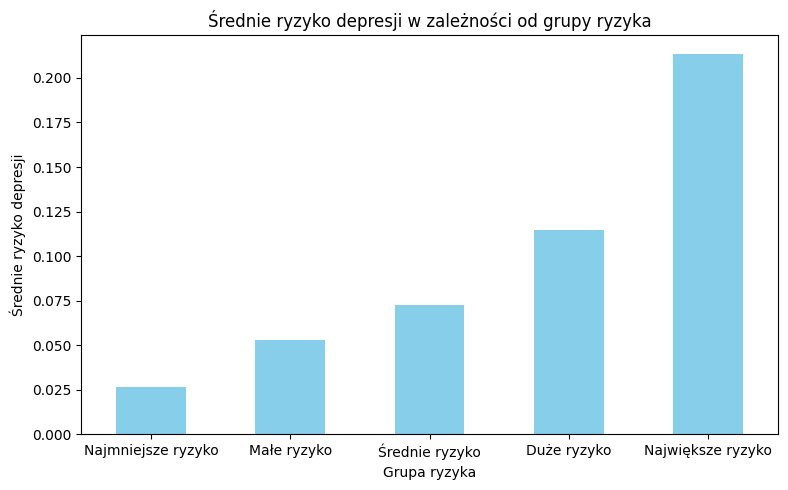

In [62]:
# Plot the depression risk groups
plt.figure(figsize=(8, 5))
depression_risk_groups.plot(kind='bar', color='skyblue')
plt.title('Średnie ryzyko depresji w zależności od grupy ryzyka')
plt.xlabel('Grupa ryzyka')
plt.ylabel('Średnie ryzyko depresji')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Na wykresie widoczne jest, że w grupie o największym ryzyku ponad 21% osób faktycznie miało depresję. W każdej kolejnej grupie odsetek osób z depresją maleje, co jest dobrym znakiem. Niepokojące jest jednak, że w dwóch najniższych grupach 2.7% i 5.3% respondentów miało silny epizod depresyjny, ponieważ gdyby ktoś stricte skupiał się na osobach wyznaczonych przez model, to móglby pominąć te osoby z grup o najmniejszym i małym ryzyku. Aby zmniejszyć odsetek w tych grupach możnaby spróbować utworzyć model, który miałby większą wartość metryki recall, jednak mogłoby to też wpłynąć na inne grupy w sposób negatywny. Inną możliwością, która mogłaby poprawić model, byłoby wykorzystanie pewnej skali (np. takiej jak w rubryce `DEPRESSIONINDEX`, gdyby była pewność, że wartości w niej są poprawne - wg autorów nie należy z tej kolumny korzystać) i uczyć model na takich danych, a nie na wartościach binarnych.

Płynie z tego wniosek, że nie można ślepo wierzyć w modele matematyczne (zwłaszcza takim prostym), ponieważ choroby są często bardziej złożone.

### Utworzenie zakresów dla poszczególnych grup ryzyka oraz walidacja

Kolejnym krokiem jest utworzenie tablicy przeglądania, która na podstawie wartości predykcji zaklasyfikuje osobę do odpowiedniej grupy ryzyka depresji.

In [63]:
depresssion_risk_groups_lookup = training_set.groupby('Prediction_bin')['Prediction_scaled'].min().to_dict()

depresssion_risk_groups_lookup[0] = - np.inf
depresssion_risk_groups_lookup = dict(sorted(depresssion_risk_groups_lookup.items(), key=lambda x: x[1], reverse=True))

In [64]:
validation_set = X_val[columns_for_model].copy()
validation_set['MDEYR'] = y_val
validation_set['Prediction'] = y_pred
validation_set['PredictionClass'] = y_pred_class

validation_set['Prediction_scaled'] = scaler.transform(validation_set[['Prediction']])

print(validation_set.head())

       DPILLALC  NEWRACE2_6  NEWRACE2_4  NEWRACE2_1  IRMARIT_4  NEWRACE2_3  \
12387       0.0         0.0         0.0         0.0        1.0         0.0   
26221       0.0         0.0         0.0         1.0        1.0         0.0   
14245       0.0         0.0         0.0         1.0        1.0         0.0   
1968        0.0         0.0         0.0         1.0        1.0         0.0   
7306        0.0         0.0         0.0         1.0        0.0         0.0   

       ANYILLICITRC  ANYCRIME  IRSEX  CRIMEHIST   HEALTH2  IREDUC2  MDEYR  \
12387           0.0       0.0    1.0        0.0  0.000000      0.4    0.0   
26221           0.0       0.0    1.0        1.0  1.000000      0.4    0.0   
14245           1.0       1.0    1.0        0.0  0.333333      0.3    1.0   
1968            1.0       0.0    0.0        0.0  0.666667      0.7    0.0   
7306            0.0       0.0    0.0        1.0  1.000000      0.2    1.0   

       Prediction  PredictionClass  Prediction_scaled  
12387   -0.0

In [65]:
# Create a function to assign depression risk group based on `Prediction_scaled`
def assign_risk_group(row):
    for group, value in depresssion_risk_groups_lookup.items():
        if row['Prediction_scaled'] >= value:
            return group
        
validation_set['Prediction_bin'] = validation_set.apply(assign_risk_group, axis=1)

print(validation_set['Prediction_bin'].value_counts())

Prediction_bin
4    1127
2    1117
0    1100
1    1081
3    1050
Name: count, dtype: int64


W zbiorze walidacyjnym grupy ryzyka również mają podobną liczebność. Ponownie jest to potwierdzenie, że model dobrze generalizuje i nie dopasowuje się tylko do jednego zbioru. Ilość osób pomiędzy grupami z największą, a najmniejszą liczebnością wynosi jedynie ok. 7%.

Dodatkowo przeprowadzony zostanie test udziału osób z depresją w każdej grupie ryzyka dla zbioru walidacyjnego.

In [66]:
depression_risk_groups_val = validation_set.groupby('Prediction_bin')['MDEYR'].mean()
depression_risk_groups_val.index = depression_risk_groups_val.index.map(depression_risk_groups_labels)
print(depression_risk_groups_val)

Prediction_bin
Najmniejsze ryzyko    0.025455
Małe ryzyko           0.057354
Średnie ryzyko        0.061773
Duże ryzyko           0.125714
Największe ryzyko     0.207631
Name: MDEYR, dtype: float64


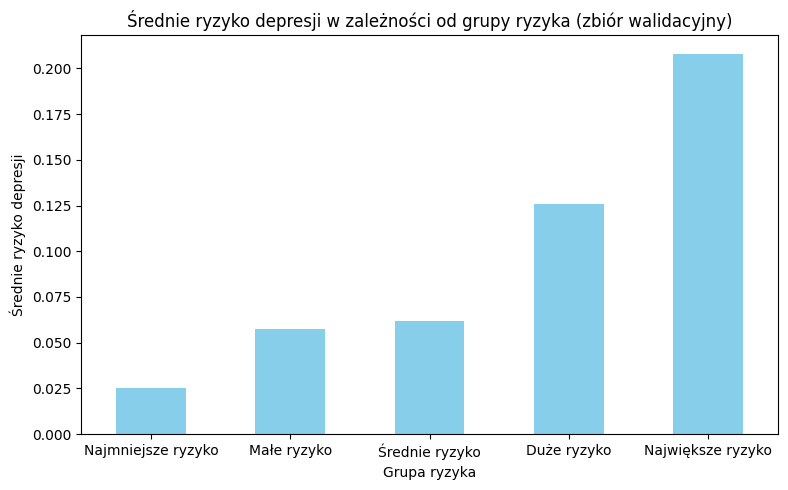

In [67]:
# Plot the depression risk groups
plt.figure(figsize=(8, 5))
depression_risk_groups_val.plot(kind='bar', color='skyblue')
plt.title('Średnie ryzyko depresji w zależności od grupy ryzyka (zbiór walidacyjny)')
plt.xlabel('Grupa ryzyka')
plt.ylabel('Średnie ryzyko depresji')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Ponownie porównując średnie ryzyko depresji w każdej grupie można zauważyć, że wartości te są podobne dla zbioru treningowego i walidacyjnego. Do pozytywnych obserwacji należy zaliczyć zmniejszenie się (co prawda raptem o 0.1 punkta procentowego) występowania depresji w grupie najniższego ryzyka. Grupa średniego ryzyka zaliczyła spadek średniego ryzyka depresji o ponad 1 pp, ale kosztem wzrostu współczynnika w grupie małego ryzyka o prawie 0.5 pp. W grupie wysokiego ryzyka wartość metryki wzrosła, ale niestety w grupie największego ryzyka zmniejszyła się, co w przypadku, gdy osoby z grupy najwyższego ryzyka byłyby dokładnie obserwowane i poświęcanoby na takie osoby więcej czasu i pieniędzy, to większa część z nich byłaby poświęcona na osoby, które tej depresji nie mają (w porównaniu do osób ze zbioru treningowego).

### Analiza grupy najniższego i najwyższego ryzyka

W tej części przeprowadzone zostanie porównanie wszystkich cech wykorzystanych przy predykcji. W tym celu wykorzystane zostaną wartości średnie, mediana oraz wartość 25 i 75 percentyla dla każdej cechy dla osób ze zbioru treningowego z grup najniższego i najwyższego ryzyka.

In [68]:
print(training_set[training_set['Prediction_bin'] == 0].describe())

       DPILLALC   NEWRACE2_6   NEWRACE2_4   NEWRACE2_1    IRMARIT_4  \
count    6280.0  6280.000000  6280.000000  6280.000000  6280.000000   
mean        0.0     0.015446     0.002866     0.507484     0.299682   
std         0.0     0.123328     0.053465     0.499984     0.458155   
min         0.0     0.000000     0.000000     0.000000     0.000000   
25%         0.0     0.000000     0.000000     0.000000     0.000000   
50%         0.0     0.000000     0.000000     1.000000     0.000000   
75%         0.0     0.000000     0.000000     1.000000     1.000000   
max         0.0     1.000000     1.000000     1.000000     1.000000   

        NEWRACE2_3  ANYILLICITRC     ANYCRIME        IRSEX    CRIMEHIST  \
count  6280.000000   6280.000000  6280.000000  6280.000000  6280.000000   
mean      0.017197      0.049204     0.005255     0.920860     0.091242   
std       0.130017      0.139147     0.072305     0.269979     0.287976   
min       0.000000      0.000000     0.000000     0.000000  

In [69]:
print(training_set[training_set['Prediction_bin'] == 4].describe())

          DPILLALC   NEWRACE2_6   NEWRACE2_4   NEWRACE2_1    IRMARIT_4  \
count  6199.000000  6199.000000  6199.000000  6199.000000  6199.000000   
mean      0.306824     0.045975     0.004356     0.751250     0.725924   
std       0.461213     0.209448     0.065858     0.432323     0.446084   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     1.000000     0.000000   
50%       0.000000     0.000000     0.000000     1.000000     1.000000   
75%       1.000000     0.000000     0.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

        NEWRACE2_3  ANYILLICITRC     ANYCRIME        IRSEX    CRIMEHIST  \
count  6199.000000   6199.000000  6199.000000  6199.000000  6199.000000   
mean      0.016777      0.648922     0.300048     0.279077     0.258429   
std       0.128445      0.363249     0.458316     0.448582     0.437806   
min       0.000000      0.000000 

Przygotowanie wykresów do wizualizacji wyników

<Figure size 1200x800 with 0 Axes>

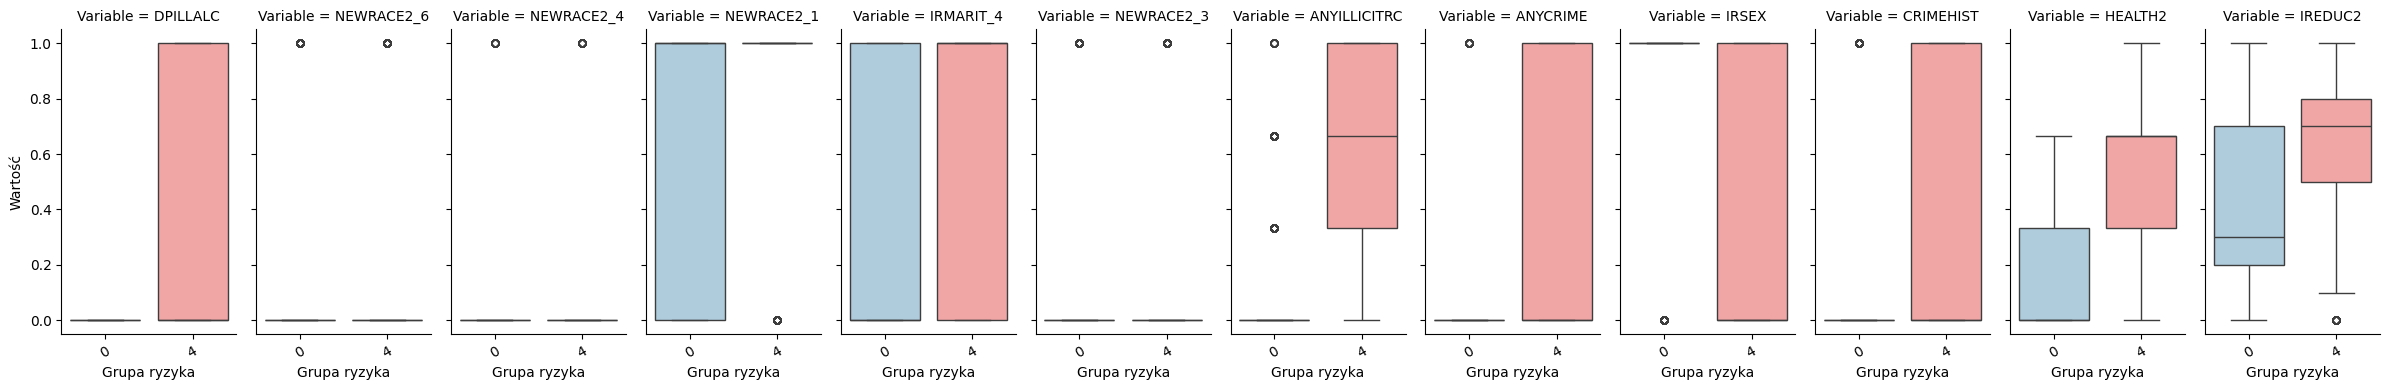

In [70]:
numeric_cols = list(columns_for_model.copy())

melted_df = training_set.melt(
    id_vars=['Prediction_bin'],
    value_vars=numeric_cols,
    var_name='Variable',
    value_name='Value'
)

plt.figure(figsize=(12, 8))
g = sns.catplot(
    data=melted_df,
    x='Prediction_bin',
    y='Value',
    hue='Prediction_bin',
    col='Variable',
    kind='box',
    palette='Paired',
    height=4,
    aspect=0.5,
    order=[0, 4],
    legend=False
)

g.set_xticklabels(rotation=30)
g.set_axis_labels("Grupa ryzyka", "Wartość")
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

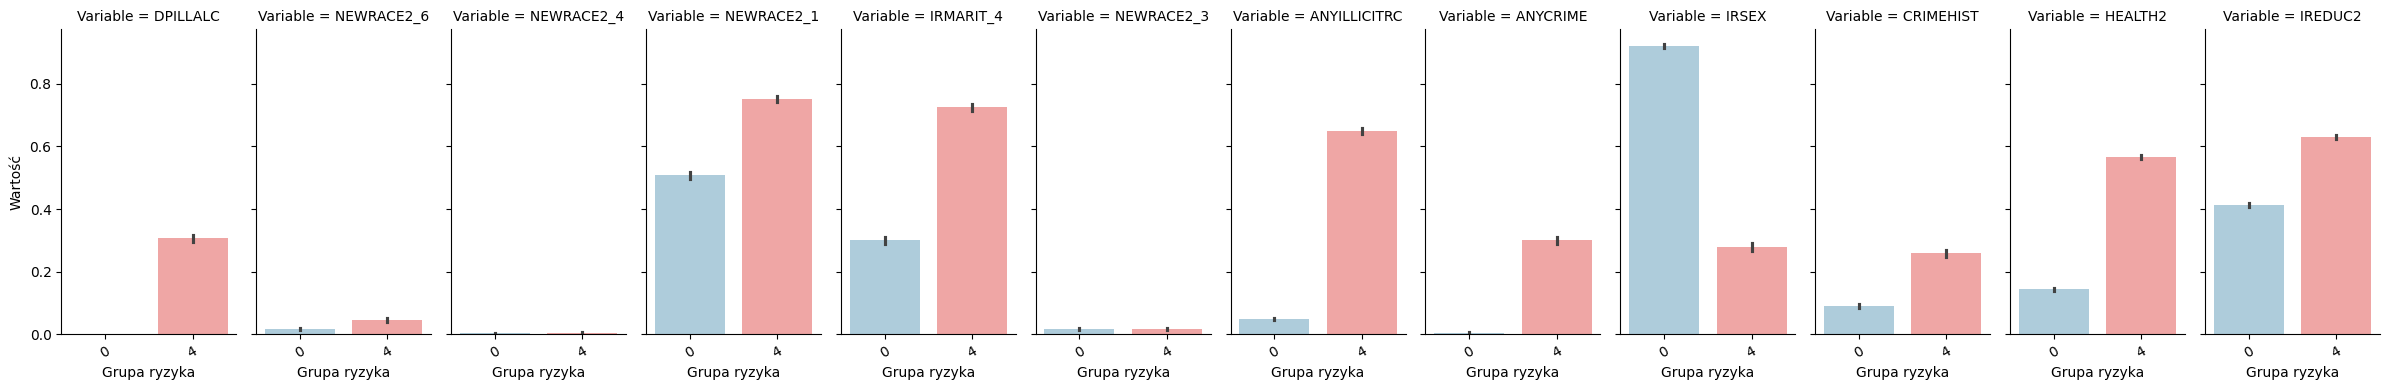

In [71]:
numeric_cols = list(columns_for_model.copy())

melted_df = training_set.melt(
    id_vars=['Prediction_bin'],
    value_vars=numeric_cols,
    var_name='Variable',
    value_name='Value'
)

plt.figure(figsize=(12, 8))
g = sns.catplot(
    data=melted_df,
    x='Prediction_bin',
    y='Value',
    hue='Prediction_bin',
    col='Variable',
    kind='bar',
    palette='Paired',
    height=4,
    aspect=0.5,
    order=[0, 4],
    legend=False
)

g.set_xticklabels(rotation=30)
g.set_axis_labels("Grupa ryzyka", "Wartość")
plt.tight_layout()
plt.show()

Analiza zostanie przeprowadzona poprzez porównanie oddzielnie każdej cechy dla tych 2 grup ryzyka:
- `DPILLALC` (uzależnienie od narkotyków lub alkoholu w ostatnim roku): w grupie najniższego ryzyka nikt nie był uzależniony od nartkotyków lub alkoholu w ostatnim roku, w grupie najwyższego ryzyka ok. 30% było uzależnionych - **oznacza to, że wg modelu uzależnienie od używek zwiększa prawdopodobieństwo depresji**;
- `NEWRACE2_6`, `NEWRACE2_4`, `NEWRACE2_1`, `NEWRACE2_3` (kolejno: więcej niż 1 rasa, z Hawajów/innych wysp na Pacyfiku, biała, rdzenny Amerykanin): w grupie najwyższego ryzyka odsetek osób, którzy zaznaczyli odpowiedź "więcej niż 1 rasa" wzrósł o 198% procent, udział osób z Hawajów/wysp na Pacyfiku wzrósł o 52%, a udział osób rasy białej zwiększył się o 48%. Odsetek rdzennych Amerykanów był wyższy w grupie najniższego ryzyka - **oznacza to, że wg modelu rasa ma wpływ na ryzyko depresji**, a dodatkowo, na podstawie wzrostów w 3 kolumnach, możemy wnioskować o tym, że udział osób pozostałych ras jest większy dla grupy najniższego ryzyka niż dla najwyższego ryzyka;
- `IRMARIT_4` (respondent nigdy nie wziął ślubu - jedynie osoby >= 15 lat): w całym zbiorze 49.6% respondentów odpowiedziała, że nigdy nie wzięła ślubu, ale jak widać na wykresach powyżej, w grupie o podwyższonym ryzyku depresji osoby takie stanowią większość (aż 72.5%), za to w grupie najniższego ryzyka odsetek ten wynosi 30% - **oznacza to, że brak ślubu w swoim życiu zwiększa prawdopodobieństwo wystąpienia depresji**;
- `ANYILLICITRC` (kiedy ostatni raz respondent wziął jakąkolwiek nielegalną substancję - 0: nigdy, 0.33: więcej niż rok temu, 0.66: dawniej niż miesiąc temu, ale w ostatnim roku, 1: w ciągu ostatnich 30 dni): w przypadku grupy najniższego ryzyka 75 percentyl wynosi 0 (czyli nigdy nie brali narkotyków), ale zdarzyły się bardzo nieliczne przypadki osób w każdej "grupie czasowej", w tym nawet w ciągu ostatnich 30 dni. Dla grupy najwyższego ryzyka średnia wartość wynosi 0.65 (czyli średnio wszyscy ostatni raz użyli narkotyków około rok temu), ale 75 percentyl wynosi 1, więc przynajmniej 25% respondentów wziąło narkotyki w ciągu ostatnich 30 dni, a 25 percentyl wynosi 0.33, więc osób, które nigdy nie brały narkotyków w tej grupie jest poniżej 25% (dodatkowo dla porównania, w całym zbiorze odpowiedź "nigdy" wybrało 52.4%) - **oznacza to (podobnie jak w pierwszej analizowanej kolumnie), że używanie substancji w niedalekiej przeszłości zwiększa ryzyko depresji**;
- `ANYCRIME` (czy kiedykolwiek popełnił przestępstwo - zarówno jako dorosły lub dziecko): w grupie najniższego ryzyka, raptem 0.5% osób popełniło przestępstwo, za to w grupie najwyższego ryzyka odsetek ten wynosi aż 30% (dla porównania w całym zbiorze raptem 8.6% respondentów zaznaczyło popełnienie przestępstwa) - **oznacza to, że popełnienie przestępstwa zwiększa ryzyko wystąpiena depresji**;
- `IRSEX` (płeć - 0: kobieta, 1: mężczyzna): w grupie najniższego ryzyka mężczyźni stanowią aż 92% populacji grupy, a w przeciwnej grupie to kobiety stanowią większość (72% liczebności grupy) - **oznacza to, że płeć wpływa na prawdopodobieństwo depresji - kobiety mają to prawdopodobieństwo większe**;
- `CRIMEHIST` (kiedykolwiek aresztowany i notowany za popełnienie przestępstwa): w grupie najniższego ryzyka 9% respondentów odpowiedziało, że zostali w przeszłości aresztowani (ciekawy jest fakt, że tylko 0.5% zaznaczyło, że popełnili przestępstwo), a w grupie najwyższego ryzyka stanowili oni 26% liczebności grupy - **oznacza to, że bycie aresztowanym w przeszłości zwiększa prawdopodobieństwo wystąpienia depresji**;
- `HEALTH2` (ogólne zdrowie - 0: znakomicie, 0.33: bardzo dobrze, 0.66: dobrze, 1: w porządku/źle): w grupie najniższego ryzyka nikt nie oznaczył swojego stanu zdrowia jako "w porządku/źle", a dodatkowo przynajmniej 75% oznaczyło jako znakomite lub bardzo dobre; w grupie najwyższego ryzyka znajduje się przynajmniej jeden respondent dla każdej grupy zdrowotnej, ale średnia odpowiedź jest pomiędzy dobrze, a bardzo dobrze (z niewielką przewagą w kierunku dobrze) - **oznacza to, że dobry stan zdrowia powoduje mniejsze prawdopodobieństwo wystąpienia depresji**;
- `IREDUC2` (poziom edukacji - 0: piąta klasa lub niżej, co 0.1 jedna klasa wyżej, 0.9: klasa 14 lub 15, 1.0: klasa 16/studia magisterskie lub wyższe) - w obu przypadkach zakres odpowiedzi jest od 0 do 1, ale rozkład jest inny. W grupie najniższego ryzyka mediana wynosi 0.3 (8 klasa), a 75 percentyl 0.7 (12 klasa) - dla grupy najwyższego ryzyka 0.7 to mediana, a 25 percentyl wynosi 0.5 (10 klasa) - **oznacza to, że wyższy poziom wykształcenia zwiększa prawdopodobieństwo wystąpienia depresji**.

### Przetestowanie wniosków

Na koniec wykonany zrobiony test, w którym sztucznie zostaną utworzone 2 "osoby", a następnie przeprowadzona zostanie predykcja prawdopodobieństwa wystąpienia depresji. Będą one stworzone na podstawie analizy z poprzedniej części i jedna z nich będzie miała mieć jak najmniejsze prawdopodobieństwo wystąpienia depresji, a druga jak największe. "Osoby" te będą miały następujące cechy:
- potencjalne największe ryzyko: kobieta (`IRSEX = 0`) o najwyższym możliwym wykształceniu (`IREDUC2 = 1`), która zaznaczyła w kwestionariuszu "więcej niż 1 rasa" (`NEWRACE2_6 = 1`), dodatkowo nigdy nie była mężata (`IRMARIT_4 = 1`), brała w ostatnich 30 dniach nielegalne substancje (`ANYILLICITRC = 1`) i jest uzależniona od używek (`DPILLALC = 1`), popełniła kiedyś przestępstwo (`ANYCRIME = 1`), za które była aresztowana (`CRIMEHIST = 1`), a jej stan zdrowia jest zły (`HEALTH2 = 1`);
- potencjalnie najmniejsze ryzyko: mężczyzna (`IRSEX = 1`), który jest w 5 klasie (`IREDUC2 = 0`) i jest rdzennym Amerykaninem (`NEWRACE2_3 = 1`), który wziął ślub (`IRMARIT_4 = 0`), nigdy nie brała nielegalnych substancji (`ANYILLICITRC = 0`), więc nie może być od nich uzależniony (`DPILLALC = 0`), nigdy nie popełnił przestępstwa (`ANYCRIME = 0`), więc nie był też aresztowany (`CRIMEHIST = 0`), a jego stan zdrowia jest znakomity (`HEALTH2 = 0`).

In [72]:
conclusions_verification = pd.DataFrame(columns=columns_for_model)

conclusions_verification.loc[0] = 0
conclusions_verification.loc[0, 'IRSEX'] = 0
conclusions_verification.loc[0, 'IREDUC2'] = 1
conclusions_verification.loc[0, 'NEWRACE2_6'] = 1
conclusions_verification.loc[0, 'IRMARIT_4'] = 1
conclusions_verification.loc[0, 'ANYILLICITRC'] = 1
conclusions_verification.loc[0, 'DPILLALC'] = 1
conclusions_verification.loc[0, 'ANYCRIME'] = 1
conclusions_verification.loc[0, 'CRIMEHIST'] = 1
conclusions_verification.loc[0, 'HEALTH2'] = 1

conclusions_verification.loc[1] = 0
conclusions_verification.loc[1, 'IRSEX'] = 1
conclusions_verification.loc[1, 'NEWRACE2_3'] = 1

print(conclusions_verification)

   DPILLALC  NEWRACE2_6  NEWRACE2_4  NEWRACE2_1  IRMARIT_4  NEWRACE2_3  \
0         1           1           0           0          1           0   
1         0           0           0           0          0           1   

   ANYILLICITRC  ANYCRIME  IRSEX  CRIMEHIST  HEALTH2  IREDUC2  
0             1         1      0          1        1        1  
1             0         0      1          0        0        0  


In [73]:
# Predict the depression risk group for the conclusions_verification
conclusions_verification['Prediction'] = model.predict(conclusions_verification)
conclusions_verification['Prediction_scaled'] = scaler.transform(conclusions_verification[['Prediction']])
conclusions_verification['Prediction_bin'] = conclusions_verification.apply(assign_risk_group, axis=1)

print(conclusions_verification)

   DPILLALC  NEWRACE2_6  NEWRACE2_4  NEWRACE2_1  IRMARIT_4  NEWRACE2_3  \
0         1           1           0           0          1           0   
1         0           0           0           0          0           1   

   ANYILLICITRC  ANYCRIME  IRSEX  CRIMEHIST  HEALTH2  IREDUC2  Prediction  \
0             1         1      0          1        1        1    0.442889   
1             0         0      1          0        0        0   -0.064978   

   Prediction_scaled  Prediction_bin  
0           1.005799               4  
1           0.010515               0  


Jak widać wnioski dobrze przedstawiają to, jak model interpretuje cechy. Osoba, która miała mieć największe prawdopodobieństwo depresji, ma na to aż 100.6% (wartość wyszła poza zakres, bo w danych treningowych żadnego tak ekstremalnego przypadku nie było), a za to osoba, która miała mieć małe prawdopodobieństwo depresji ma raptem ok. 1% szans na silny epizod depresyjny.